In [1]:
# загрузка библиотек

# методы для отрисовки изображений
from PIL import Image, ImageEnhance

# Для отрисовки графиков
import matplotlib.pyplot as plt

# Для генерации случайных чисел
import random

# Библиотека работы с массивами
import numpy as np
import pandas as pd

# Для работы с файлами
import os
from os import listdir

# Модуль Garbage Collector - для помощи в освобождении памяти (Удаляет лишние/неиспользуемые данные)
import gc

# импортируем модуль для загрузки данных
import gdown

# для разделения выборок
from sklearn.model_selection import train_test_split

# создание последовательной модели
from tensorflow.keras.models import Sequential

# слои нейронной сети
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# Работа с изображениями
#from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

# оптимизатор
from tensorflow.keras.optimizers import Adam

# импорт tensorflow
import tensorflow as tf

# модуль для отсчета времени
import time

# Для отрисовки графиков
import seaborn as sns
import warnings

In [3]:
# Загрузка датасетов из облака
gdown.download('https://lodmedia.hb.bizmrg.com/case_files/1128568/train_dataset_soc_dem_train.zip', None, quiet=True)
!unzip -q "/content/train_dataset_soc_dem_train.zip" -d /content/ # подгрузим базу в ноутбук в директорию 'content/'

In [52]:
path = "" #... # Ваш путь до директории с данными /path/to/data/
data = pd.read_csv(path + 'train_events.csv')
video = pd.read_csv(path + 'video_info_v2.csv')
targets = pd.read_csv(path + 'train_targets.csv')
full_data = pd.read_csv(path + 'all_events.csv')
regi = pd.read_csv(path + 'region.csv')

## **Данные для задачи «Предсказание социально-демографических характеристик пользователя»**

Данные для задачи «Предсказание социальнодемографических характеристик пользователя» состоят из
следующих таблиц:
1. all_events.csv— Данные с историей просмотров пользователей
Описание признаков:
viewer_uid: id пользователя
rutube_video_id: id видео
event_timestamp: Дата
события
region: Регион
ua_device_type: Тип устройства пользователя
ua_client_type: Браузер/приложение
ua_os: Название операционной системы пользователя
ua_client_name: Название браузера пользователя
total_watchtime: Время просмотра в секундах
Прим.: В колонке event_timestamp указано московское
время (GMT +3). Используйте данные из region, чтобы
привести время к региональному
2. train_events.csv — Данные с историей просмотров пользователей с известными
целевыми переменными
Описание признаков:
event_ timestamp: Дата
события
viewer_uid: id пользователя
rutube_video_id: id видео
region: Регион
ua_device_type: Тип устройства пользователя
ua_client_type: Браузер/приложение
ua_os: Название операционной системы пользователя
ua_client_name: Название браузера пользователя
total_watchtime: Время просмотра в секундах
Прим.: В колонке event_timestamp указано московское
время (GMT +3). Используйте данные из region, чтобы
привести время к региональному
3. video_info.csv — Данные с информацией о видео
Описание признаков:
rutube_video_id: id видео
title: название видео
duration: длительность видео в миллисекундах
author_id: id автора видео
category: категория видео
4. train_targets.csv — Целевые переменные пользователей из таблицы train_events
Описание признаков:
viewer_uid: id пользователя
age: возраст пользователя
sex: Пол пользователя
age_class: возрастная категория пользователя
Прим.: Возрастные категории разделены следующим образом:
0 – (9, 20] (лет)
1 – (20, 30] (лет)
2 – (30, 40] (лет)
3 – (40, 60] (лет)
Вы можете обучать алгоритм в задаче мультиклассовой классификации возрастной группы,
но также и в задаче регрессии, самостоятельно определив категорию пользователя по
предсказанному количеству лет.
5. sample_submission.csv — Пример таблицы с предсказаниями модели участников
Описание признаков:
viewer_uid: id пользователя из тестовой выборки
sex: Предсказанный пол пользователя
age_class: Предсказанная возрастная категория пользовател

In [75]:
full_data # Данные с историей просмотров пользователей

,event_timestamp,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid
0,2024-06-01 13:08:30+03:00,Tatarstan Republic,smartphone,browser,Android,Chrome Mobile,60,video_395879,10813370
1,2024-06-01 14:30:00+03:00,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,60,video_216518,10512324
2,2024-06-01 18:48:12+03:00,Novosibirsk Oblast,smartphone,mobile app,Android,Rutube,121,video_41225,10951137
3,2024-06-01 16:32:36+03:00,Moscow,desktop,browser,Windows,Yandex Browser,2324,video_215886,10912434
4,2024-06-01 00:57:04+03:00,Moscow Oblast,smartphone,mobile app,Android,Rutube,6830,video_43631,10223585
...,...,...,...,...,...,...,...,...,...
8439619,2024-06-30 18:12:06+03:00,Nizhny Novgorod Oblast,smartphone,mobile app,Android,Rutube,1735,video_163270,10687999
8439620,2024-06-30 09:23:08+03:00,Chelyabinsk,smartphone,mobile app,Android,Rutube,4766,video_433627,10425804
8439621,2024-06-30 10:57:36+03:00,Krasnodar Krai,smartphone,mobile app,Android,Rutube,890,video_11911,10565147
8439622,2024-06-30 18:16:55+03:00,Moscow,smartphone,browser,Android,Yandex Browser,2504,video_252573,10715847


In [76]:
data  #Данные с историей просмотров пользователей с известными целевыми переменными

,event_timestamp,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid
0,2024-06-01 06:40:58+03:00,Chelyabinsk,desktop,browser,Windows,Yandex Browser,1883,video_133074,10067243
1,2024-06-01 19:33:24+03:00,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,512,video_362960,10245341
2,2024-06-01 21:30:43+03:00,St.-Petersburg,desktop,browser,Windows,Chrome,5647,video_96775,10894333
3,2024-06-01 23:03:42+03:00,Moscow,smartphone,mobile app,Android,Rutube,1521,video_161610,10029092
4,2024-06-01 22:48:09+03:00,Moscow,smartphone,mobile app,Android,Rutube,71,video_116245,10452976
...,...,...,...,...,...,...,...,...,...
1759611,2024-06-30 17:08:36+03:00,Moscow,smartphone,mobile app,Android,Rutube,4230,video_162776,10026914
1759612,2024-06-30 01:20:16+03:00,Moscow,smartphone,browser,Android,Firefox Mobile,382,video_316157,10417567
1759613,2024-06-30 22:37:04+03:00,St.-Petersburg,desktop,browser,Windows,Microsoft Edge,1342,video_83304,10009094
1759614,2024-06-30 11:33:09+03:00,St.-Petersburg,smartphone,mobile app,Android,Rutube,801,video_132769,10574374


In [77]:
video

,rutube_video_id,title,category,duration,author_id
0,video_185549,Как собрать букет из мыльных тюльпанов - Силик...,Хобби,1559160,1015054
1,video_111035,"Осторожно, Киберземляне!, 1 сезон, 12 серия",Сериалы,1320007,1002180
2,video_476517,ПОПУЛЯРНЫЕ ВИДЕОИГРЫ в LEGO... перевод - TD BR...,Хобби,606145,1095337
3,video_157198,"Хороший лжец (фильм, 2019)",Фильмы,6577440,1043618
4,video_289824,Нашего старого гнобят по-всякому,Развлечения,859493,1009535
...,...,...,...,...,...
481475,video_196126,14. Landscape Layer Blend,Дизайн,462000,1121338
481476,video_390909,Рихард Штраус: Завтра! — Людмила Рубинская,Музыка,227628,1043510
481477,video_326364,"Поймай Тинипин! Королевство эмоций, 2 серия. С...",Мультфильмы,744576,1002799
481478,video_374957,ВОРКУТА. 1 СЕРИЯ. УЖАСЫ. ПСИХОЛОГИЧЕСКИЙ ТРИЛЛЕР,Люди и блоги,2597385,1008386


In [79]:
targets

,viewer_uid,age,sex,age_class
0,10087154,30,male,1
1,10908708,25,female,1
2,10190464,34,male,2
3,10939673,25,male,1
4,10288257,48,male,3
...,...,...,...,...
180007,10237402,43,female,3
180008,10796936,32,male,2
180009,10684284,28,male,1
180010,10031093,50,female,3


## **EDA**

In [5]:
# смотрим пропушенные данные
full_data.isna().sum(axis=0)

,0
event_timestamp,0
region,0
ua_device_type,0
ua_client_type,13
ua_os,519630
ua_client_name,13
total_watchtime,0
rutube_video_id,0
viewer_uid,0


In [80]:
# смотрим пропушенные данные
data.isna().sum(axis=0)

,0
event_timestamp,0
region,0
ua_device_type,0
ua_client_type,0
ua_os,117671
ua_client_name,0
total_watchtime,0
rutube_video_id,0
viewer_uid,0


In [25]:
#собираем тренировочный датасет
df_merged = targets.merge(data, on='viewer_uid', how='outer')
data_video=df_merged.merge(video[['rutube_video_id','author_id','title','category','duration']], how='left')
data_video

,viewer_uid,age,sex,age_class,event_timestamp,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,author_id,title,category,duration
0,10087154,30,male,1,2024-06-24 18:27:25+03:00,Krasnoyarsk Krai,smartphone,mobile app,Android,Rutube,511,video_47774,1034175,"Они звери, а мы — нет // Дмитрий Пучков про уг...",Интервью,4696127
1,10087154,30,male,1,2024-06-25 18:50:57+03:00,Novosibirsk Oblast,smartphone,mobile app,Android,Rutube,531,video_47774,1034175,"Они звери, а мы — нет // Дмитрий Пучков про уг...",Интервью,4696127
2,10908708,25,female,1,2024-06-05 15:27:59+03:00,St.-Petersburg,smartphone,mobile app,Android,Rutube,68,video_434445,1017256,"ЫРКА, ЛЕШИЙ, БАКУ И ЖУТКАЯ НОЧЕВКА !",Развлечения,601003
3,10908708,25,female,1,2024-06-21 12:27:23+03:00,Moscow Oblast,smartphone,mobile app,Android,Rutube,581,video_105981,1017256,ЫРКА! НИКОГДА НЕ РАЗГОВАРИВАЙ С НИМ! ЭТО КОНЕЦ...,Развлечения,593920
4,10908708,25,female,1,2024-06-21 12:16:26+03:00,Moscow Oblast,smartphone,mobile app,Android,Rutube,631,video_26272,1017256,СОНЯ СТАЛА ЫРКОЙ!,Развлечения,658240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1759611,10035024,26,female,1,2024-06-30 06:28:25+03:00,Tomsk Oblast,smartphone,mobile app,Android,Rutube,1119,video_251738,1120873,Сериал Элементарно - 1 Сезон 1 Серия / Elemen...,Сериалы,2744286
1759612,10035024,26,female,1,2024-06-30 11:35:17+03:00,Tomsk Oblast,smartphone,mobile app,Android,Rutube,2591,video_86180,1120873,Сериал Элементарно - 1 Сезон 4 Серия / Elemen...,Сериалы,2592427
1759613,10035024,26,female,1,2024-06-30 09:53:23+03:00,Tomsk Oblast,smartphone,mobile app,Android,Rutube,2590,video_150355,1120873,Сериал Элементарно - 1 Сезон 3 Серия / Elemen...,Сериалы,2595735
1759614,10035024,26,female,1,2024-06-30 13:41:39+03:00,Tomsk Oblast,smartphone,mobile app,Android,Rutube,2591,video_28173,1120873,Сериал Элементарно - 1 Сезон 6 Серия / Elemen...,Сериалы,2597129


In [6]:
freg=full_data['region'].value_counts()
freg

,count
region,
Moscow,1787982
St.-Petersburg,566934
Moscow Oblast,474697
Sverdlovsk Oblast,333532
Samara Oblast,313082
...,...
Smolensk,471
Jewish Autonomous Oblast,433
Stavropol Krai,418


In [72]:
freg.to_csv('region.csv')

In [7]:
fdev=full_data['ua_device_type'].value_counts()
fdev

,count
ua_device_type,
smartphone,6439053
desktop,1638069
tablet,362502


In [8]:
fcli=full_data['ua_client_type'].value_counts()
fcli

,count
ua_client_type,
mobile app,5422565
browser,3016838
av,208


In [9]:
fosa=full_data['ua_os'].value_counts()
fosa

,count
ua_os,
Android,5846495
Windows,1492259
iOS,429418
Mac,121609
GNU/Linux,22654
iPadOS,4418
Ubuntu,1535
android tv,758
Windows Phone,162


In [10]:
fclinam=full_data['ua_client_name'].value_counts()
fclinam

,count
ua_client_name,
Rutube,5415545
Chrome,822447
Yandex Browser,701136
Chrome Mobile,674439
Mobile Safari,226530
...,...
Stargon,1
Petal Search App,1
Phoenix Browser,1


In [12]:
data_video


,viewer_uid,age,sex,age_class,event_timestamp,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,author_id,title,category,duration
0,10087154,30,male,1,2024-06-24 18:27:25+03:00,Krasnoyarsk Krai,smartphone,mobile app,Android,Rutube,511,video_47774,1034175,"Они звери, а мы — нет // Дмитрий Пучков про уг...",Интервью,4696127
1,10087154,30,male,1,2024-06-25 18:50:57+03:00,Novosibirsk Oblast,smartphone,mobile app,Android,Rutube,531,video_47774,1034175,"Они звери, а мы — нет // Дмитрий Пучков про уг...",Интервью,4696127
2,10908708,25,female,1,2024-06-05 15:27:59+03:00,St.-Petersburg,smartphone,mobile app,Android,Rutube,68,video_434445,1017256,"ЫРКА, ЛЕШИЙ, БАКУ И ЖУТКАЯ НОЧЕВКА !",Развлечения,601003
3,10908708,25,female,1,2024-06-21 12:27:23+03:00,Moscow Oblast,smartphone,mobile app,Android,Rutube,581,video_105981,1017256,ЫРКА! НИКОГДА НЕ РАЗГОВАРИВАЙ С НИМ! ЭТО КОНЕЦ...,Развлечения,593920
4,10908708,25,female,1,2024-06-21 12:16:26+03:00,Moscow Oblast,smartphone,mobile app,Android,Rutube,631,video_26272,1017256,СОНЯ СТАЛА ЫРКОЙ!,Развлечения,658240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1759611,10035024,26,female,1,2024-06-30 06:28:25+03:00,Tomsk Oblast,smartphone,mobile app,Android,Rutube,1119,video_251738,1120873,Сериал Элементарно - 1 Сезон 1 Серия / Elemen...,Сериалы,2744286
1759612,10035024,26,female,1,2024-06-30 11:35:17+03:00,Tomsk Oblast,smartphone,mobile app,Android,Rutube,2591,video_86180,1120873,Сериал Элементарно - 1 Сезон 4 Серия / Elemen...,Сериалы,2592427
1759613,10035024,26,female,1,2024-06-30 09:53:23+03:00,Tomsk Oblast,smartphone,mobile app,Android,Rutube,2590,video_150355,1120873,Сериал Элементарно - 1 Сезон 3 Серия / Elemen...,Сериалы,2595735
1759614,10035024,26,female,1,2024-06-30 13:41:39+03:00,Tomsk Oblast,smartphone,mobile app,Android,Rutube,2591,video_28173,1120873,Сериал Элементарно - 1 Сезон 6 Серия / Elemen...,Сериалы,2597129


In [13]:
reg=data['region'].value_counts()
reg

,count
region,
Moscow,383837
Moscow Oblast,118455
St.-Petersburg,117196
Sverdlovsk Oblast,71201
Krasnodar Krai,70567
...,...
Ingushetiya Republic,113
Omsk,113
Stavropol Krai,110


In [14]:
dev=data['ua_device_type'].value_counts()
dev

,count
ua_device_type,
smartphone,1192721
desktop,463165
tablet,103730


In [15]:
cli=data['ua_client_type'].value_counts()
cli

,count
ua_client_type,
mobile app,1140259
browser,619338
av,19


In [16]:
osa=data['ua_os'].value_counts()
osa

,count
ua_os,
Android,1131036
Windows,398698
Mac,55179
iOS,45672
GNU/Linux,8712
iPadOS,1189
Ubuntu,588
Windows Phone,259
android tv,191


In [17]:
clinam=data['ua_client_name'].value_counts()
clinam

,count
ua_client_name,
Rutube,1138818
Yandex Browser,230202
Chrome,161821
Chrome Mobile,62040
Mobile Safari,32955
Safari,28641
Microsoft Edge,25502
Firefox Mobile,23985
Opera,21373


In [18]:
data.isna().sum(axis=0)

,0
event_timestamp,0
region,0
ua_device_type,0
ua_client_type,0
ua_os,117671
ua_client_name,0
total_watchtime,0
rutube_video_id,0
viewer_uid,0


In [29]:
#data_video=df_merged.merge(video[['rutube_video_id','author_id','title','category','duration']], how='left')
data_video

,viewer_uid,age,sex,age_class,event_timestamp,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,author_id,title,category,duration
0,10087154,30,male,1,2024-06-24 18:27:25+03:00,Krasnoyarsk Krai,smartphone,mobile app,Android,Rutube,511,video_47774,1034175,"Они звери, а мы — нет // Дмитрий Пучков про уг...",Интервью,4696127
1,10087154,30,male,1,2024-06-25 18:50:57+03:00,Novosibirsk Oblast,smartphone,mobile app,Android,Rutube,531,video_47774,1034175,"Они звери, а мы — нет // Дмитрий Пучков про уг...",Интервью,4696127
2,10908708,25,female,1,2024-06-05 15:27:59+03:00,St.-Petersburg,smartphone,mobile app,Android,Rutube,68,video_434445,1017256,"ЫРКА, ЛЕШИЙ, БАКУ И ЖУТКАЯ НОЧЕВКА !",Развлечения,601003
3,10908708,25,female,1,2024-06-21 12:27:23+03:00,Moscow Oblast,smartphone,mobile app,Android,Rutube,581,video_105981,1017256,ЫРКА! НИКОГДА НЕ РАЗГОВАРИВАЙ С НИМ! ЭТО КОНЕЦ...,Развлечения,593920
4,10908708,25,female,1,2024-06-21 12:16:26+03:00,Moscow Oblast,smartphone,mobile app,Android,Rutube,631,video_26272,1017256,СОНЯ СТАЛА ЫРКОЙ!,Развлечения,658240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1759611,10035024,26,female,1,2024-06-30 06:28:25+03:00,Tomsk Oblast,smartphone,mobile app,Android,Rutube,1119,video_251738,1120873,Сериал Элементарно - 1 Сезон 1 Серия / Elemen...,Сериалы,2744286
1759612,10035024,26,female,1,2024-06-30 11:35:17+03:00,Tomsk Oblast,smartphone,mobile app,Android,Rutube,2591,video_86180,1120873,Сериал Элементарно - 1 Сезон 4 Серия / Elemen...,Сериалы,2592427
1759613,10035024,26,female,1,2024-06-30 09:53:23+03:00,Tomsk Oblast,smartphone,mobile app,Android,Rutube,2590,video_150355,1120873,Сериал Элементарно - 1 Сезон 3 Серия / Elemen...,Сериалы,2595735
1759614,10035024,26,female,1,2024-06-30 13:41:39+03:00,Tomsk Oblast,smartphone,mobile app,Android,Rutube,2591,video_28173,1120873,Сериал Элементарно - 1 Сезон 6 Серия / Elemen...,Сериалы,2597129


In [26]:
gender_map = {'female': 1, 'male': 0}
data_video['sex_n'] = data_video['sex'].map(gender_map)


In [27]:
device_type_map = {'smartphone': 0,'desktop': 1, 'tablet': 2}
data_video['ua_device_type_n'] = data_video['ua_device_type'].map(device_type_map)

In [31]:
client_type_map = {'av': 0,'browser': 1, 'mobile app': 2}
data_video['ua_client_type_n'] = data_video['ua_client_type'].map(client_type_map)

In [22]:
fdev

,count
ua_device_type,
smartphone,6439053
desktop,1638069
tablet,362502


In [29]:
#data_video=df_merged.merge(video[['rutube_video_id','author_id','title','category','duration']], how='left')
data_video

,viewer_uid,age,sex,age_class,event_timestamp,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,author_id,title,category,duration,sex_n,ua_device_type_n,ua_client_type_n
0,10087154,30,male,1,2024-06-24 18:27:25+03:00,Krasnoyarsk Krai,smartphone,mobile app,Android,Rutube,511,video_47774,1034175,"Они звери, а мы — нет // Дмитрий Пучков про уг...",Интервью,4696127,0,0,NaN
1,10087154,30,male,1,2024-06-25 18:50:57+03:00,Novosibirsk Oblast,smartphone,mobile app,Android,Rutube,531,video_47774,1034175,"Они звери, а мы — нет // Дмитрий Пучков про уг...",Интервью,4696127,0,0,NaN
2,10908708,25,female,1,2024-06-05 15:27:59+03:00,St.-Petersburg,smartphone,mobile app,Android,Rutube,68,video_434445,1017256,"ЫРКА, ЛЕШИЙ, БАКУ И ЖУТКАЯ НОЧЕВКА !",Развлечения,601003,1,0,NaN
3,10908708,25,female,1,2024-06-21 12:27:23+03:00,Moscow Oblast,smartphone,mobile app,Android,Rutube,581,video_105981,1017256,ЫРКА! НИКОГДА НЕ РАЗГОВАРИВАЙ С НИМ! ЭТО КОНЕЦ...,Развлечения,593920,1,0,NaN
4,10908708,25,female,1,2024-06-21 12:16:26+03:00,Moscow Oblast,smartphone,mobile app,Android,Rutube,631,video_26272,1017256,СОНЯ СТАЛА ЫРКОЙ!,Развлечения,658240,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1759611,10035024,26,female,1,2024-06-30 06:28:25+03:00,Tomsk Oblast,smartphone,mobile app,Android,Rutube,1119,video_251738,1120873,Сериал Элементарно - 1 Сезон 1 Серия / Elemen...,Сериалы,2744286,1,0,NaN
1759612,10035024,26,female,1,2024-06-30 11:35:17+03:00,Tomsk Oblast,smartphone,mobile app,Android,Rutube,2591,video_86180,1120873,Сериал Элементарно - 1 Сезон 4 Серия / Elemen...,Сериалы,2592427,1,0,NaN
1759613,10035024,26,female,1,2024-06-30 09:53:23+03:00,Tomsk Oblast,smartphone,mobile app,Android,Rutube,2590,video_150355,1120873,Сериал Элементарно - 1 Сезон 3 Серия / Elemen...,Сериалы,2595735,1,0,NaN
1759614,10035024,26,female,1,2024-06-30 13:41:39+03:00,Tomsk Oblast,smartphone,mobile app,Android,Rutube,2591,video_28173,1120873,Сериал Элементарно - 1 Сезон 6 Серия / Elemen...,Сериалы,2597129,1,0,NaN


In [63]:
data_video.to_csv('data_video.csv')
    # path/submission.csv,
    # index=False

In [48]:
data_video.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1759616 entries, 0 to 1759615
Data columns (total 18 columns):
 #   Column           Dtype         
---  ------           -----         
 0   viewer_uid       int64         
 1   age              int64         
 2   sex              object        
 3   age_class        int64         
 4   event_timestamp  object        
 5   region           object        
 6   ua_device_type   object        
 7   ua_client_type   object        
 8   ua_os            object        
 9   ua_client_name   object        
 10  total_watchtime  int64         
 11  rutube_video_id  object        
 12  author_id        int64         
 13  title            object        
 14  category         object        
 15  duration         int64         
 16  timestamp        datetime64[ns]
 17  year             int32         
dtypes: datetime64[ns](1), int32(1), int64(6), object(10)
memory usage: 234.9+ MB


In [32]:
data_video.isna().sum(axis=0)

,0
viewer_uid,0
age,0
sex,0
age_class,0
event_timestamp,0
region,0
ua_device_type,0
ua_client_type,0
ua_os,117671
ua_client_name,0


In [33]:
data_video['timestamp'] = pd.to_datetime(data_video['event_timestamp'], format='%Y-%m-%d %H:%M:%S+03:00')  #.sort_value(by='timestamp')
data_video['year'] = data_video['timestamp'].dt.year
data_video['month'] = data_video['timestamp'].dt.month
data_video['day'] = data_video['timestamp'].dt.day
data_video['weekday'] = data_video['timestamp'].dt.weekday
data_video['hour'] = data_video['timestamp'].dt.hour


In [42]:
data_video #.sort_value(by=['timestamp'])

,viewer_uid,age,sex,age_class,event_timestamp,region,ua_device_type,ua_client_type,ua_os,ua_client_name,...,sex_n,ua_device_type_n,ua_client_type_n,timestamp,year,month,day,time,weekday,hour
0,10087154,30,male,1,2024-06-24 18:27:25+03:00,Krasnoyarsk Krai,smartphone,mobile app,Android,Rutube,...,0,0,2,2024-06-24 18:27:25,2024,6,24,0,0,18
1,10087154,30,male,1,2024-06-25 18:50:57+03:00,Novosibirsk Oblast,smartphone,mobile app,Android,Rutube,...,0,0,2,2024-06-25 18:50:57,2024,6,25,1,1,18
2,10908708,25,female,1,2024-06-05 15:27:59+03:00,St.-Petersburg,smartphone,mobile app,Android,Rutube,...,1,0,2,2024-06-05 15:27:59,2024,6,5,2,2,15
3,10908708,25,female,1,2024-06-21 12:27:23+03:00,Moscow Oblast,smartphone,mobile app,Android,Rutube,...,1,0,2,2024-06-21 12:27:23,2024,6,21,4,4,12
4,10908708,25,female,1,2024-06-21 12:16:26+03:00,Moscow Oblast,smartphone,mobile app,Android,Rutube,...,1,0,2,2024-06-21 12:16:26,2024,6,21,4,4,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1759611,10035024,26,female,1,2024-06-30 06:28:25+03:00,Tomsk Oblast,smartphone,mobile app,Android,Rutube,...,1,0,2,2024-06-30 06:28:25,2024,6,30,6,6,6
1759612,10035024,26,female,1,2024-06-30 11:35:17+03:00,Tomsk Oblast,smartphone,mobile app,Android,Rutube,...,1,0,2,2024-06-30 11:35:17,2024,6,30,6,6,11
1759613,10035024,26,female,1,2024-06-30 09:53:23+03:00,Tomsk Oblast,smartphone,mobile app,Android,Rutube,...,1,0,2,2024-06-30 09:53:23,2024,6,30,6,6,9
1759614,10035024,26,female,1,2024-06-30 13:41:39+03:00,Tomsk Oblast,smartphone,mobile app,Android,Rutube,...,1,0,2,2024-06-30 13:41:39,2024,6,30,6,6,13


In [43]:
print(data_video['year'].value_counts(dropna=False))
print(data_video['month'].value_counts(dropna=False))
print(data_video['weekday'].value_counts(dropna=False))
print(data_video['day'].value_counts(dropna=False))
print(data_video['hour'].value_counts(dropna=False))

year
2024    1759616
Name: count, dtype: int64

month
6    1759616
Name: count, dtype: int64

weekday
6    294761
0    273272
5    253496
1    247771
2    237024
3    233288
4    220004
Name: count, dtype: int64

day
9     69515
24    69142
10    69111
17    68954
16    67354
3     66065
2     64170
18    63615
25    63172
19    61891
4     60626
11    60358
20    59982
26    59670
27    58848
13    58444
12    58426
5     57037
21    56510
6     56014
14    54921
28    54805
7     53768
30    53428
8     53219
29    51981
15    51533
22    49414
1     47349
23    40294
Name: count, dtype: int64

hour
21    110240
22    106555
20    101645
19     99087
18     95677
17     90792
23     89412
13     86650
14     86464
15     86227
16     86015
12     84816
11     80834
10     77002
9      71331
0      68252
8      64059
7      54768
1      47199
6      44608
5      34710
2      34462
4      29481
3      29330
Name: count, dtype: int64


In [55]:
data_video = regi.merge(data_video, on='region', how='outer')
data_video

,region,count,hour+,viewer_uid,age,sex,age_class,event_timestamp,ua_device_type,ua_client_type,...,sex_n,ua_device_type_n,ua_client_type_n,timestamp,year,month,day,time,weekday,hour
0,Moscow,1787982,0,10288257,48,male,3,2024-06-06 14:06:16+03:00,smartphone,mobile app,...,0,0,2,2024-06-06 14:06:16,2024,6,6,3,3,14
1,Moscow,1787982,0,10736308,23,female,1,2024-06-24 23:45:41+03:00,tablet,browser,...,1,2,1,2024-06-24 23:45:41,2024,6,24,0,0,23
2,Moscow,1787982,0,10050652,48,male,3,2024-06-09 15:57:25+03:00,tablet,mobile app,...,0,2,2,2024-06-09 15:57:25,2024,6,9,6,6,15
3,Moscow,1787982,0,10050652,48,male,3,2024-06-09 15:48:46+03:00,tablet,mobile app,...,0,2,2,2024-06-09 15:48:46,2024,6,9,6,6,15
4,Moscow,1787982,0,10051529,39,male,2,2024-06-02 03:22:15+03:00,smartphone,mobile app,...,0,0,2,2024-06-02 03:22:15,2024,6,2,6,6,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1759611,Arkhangelsk Oblast,109,0,10013408,38,female,2,2024-06-29 13:48:11+03:00,smartphone,mobile app,...,1,0,2,2024-06-29 13:48:11,2024,6,29,5,5,13
1759612,Arkhangelsk Oblast,109,0,10013408,38,female,2,2024-06-29 17:55:00+03:00,smartphone,mobile app,...,1,0,2,2024-06-29 17:55:00,2024,6,29,5,5,17
1759613,Arkhangelsk Oblast,109,0,10013408,38,female,2,2024-06-29 12:53:43+03:00,smartphone,mobile app,...,1,0,2,2024-06-29 12:53:43,2024,6,29,5,5,12
1759614,Arkhangelsk Oblast,109,0,10013408,38,female,2,2024-06-29 18:45:13+03:00,smartphone,mobile app,...,1,0,2,2024-06-29 18:45:13,2024,6,29,5,5,18


In [132]:
data_vid = data_video.drop(['region','sex','event_timestamp','rutube_video_id', 'ua_device_type', 'ua_client_type', 'ua_os',\
                                           'ua_client_name', 'total_watchtime','timestamp'], axis=1)

In [134]:
data_vid.to_csv('data_vid.csv')

In [133]:
data_vid

,count,hour+,viewer_uid,age,age_class,author_id,title,category,duration,sex_n,ua_device_type_n,ua_client_type_n,year,month,day,time,weekday,hour
0,1787982,0,10288257,48,3,1010824,#МОНТЯН В ЭФИРЕ: С Грубником на связи 😉,Интервью,12196012,0,0,2,2024,6,6,3,3,14
1,1787982,0,10736308,23,1,1007611,ОБРАТНАЯ ФУНКЦИЯ Что это?! | Тригонометрия в Е...,Обучение,429917,1,2,1,2024,6,24,0,0,23
2,1787982,0,10050652,48,3,1043618,"Ход королевы 7 серия «Эндшпиль» (сериал, 2020)",Сериалы,4072736,0,2,2,2024,6,9,6,6,15
3,1787982,0,10050652,48,3,1043618,"Ход королевы 2 серия «Размены» (сериал, 2020)",Сериалы,3912609,0,2,2,2024,6,9,6,6,15
4,1787982,0,10051529,39,2,1005481,"Экстрасенсы. Битва сильнейших, 2 сезон, 8 выпу...",Телепередачи,4000000,0,0,2,2024,6,2,6,6,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1759611,109,0,10013408,38,2,1008828,«За гранью»: «Мускулистая невеста» | Выпуск от...,Телепередачи,3000920,1,0,2,2024,6,29,5,5,13
1759612,109,0,10013408,38,2,1008828,«За гранью»: «Любовь за миллионы» | Выпуск от ...,Телепередачи,3005400,1,0,2,2024,6,29,5,5,17
1759613,109,0,10013408,38,2,1008828,«За гранью»: «Проспали младенца?» | Выпуск от ...,Телепередачи,3027320,1,0,2,2024,6,29,5,5,12
1759614,109,0,10013408,38,2,1008828,«За гранью»: «Экстремальная старость» | Выпуск...,Телепередачи,3013040,1,0,2,2024,6,29,5,5,18


In [56]:
data_video.isna().sum(axis=0)

,0
region,0
count,0
hour+,0
viewer_uid,0
age,0
sex,0
age_class,0
event_timestamp,0
ua_device_type,0
ua_client_type,0


In [19]:
video.isna().sum(axis=0)

,0
rutube_video_id,0
title,0
category,0
duration,0
author_id,0


In [44]:
cat=video['category'].value_counts()
cat

,count
category,
Разное,141342
Сериалы,49860
Телепередачи,35510
Видеоигры,33585
Музыка,27295
Развлечения,22506
Фильмы,16579
Обучение,13206
Лайфстайл,12438


In [21]:
dur=video['duration'].value_counts()
dur

,count
duration,
390000,382
1320000,154
235056,150
660000,145
422049,133
...,...
888618,1
9736017,1
2776131,1


In [22]:
aur=video['author_id'].value_counts()
aur

,count
author_id,
1095392,8603
1043618,8277
1009219,7391
1048955,5638
1000015,5308
...,...
1026823,1
1108769,1
1008028,1


In [9]:
targets

,viewer_uid,age,sex,age_class
0,10087154,30,male,1
1,10908708,25,female,1
2,10190464,34,male,2
3,10939673,25,male,1
4,10288257,48,male,3
...,...,...,...,...
180007,10237402,43,female,3
180008,10796936,32,male,2
180009,10684284,28,male,1
180010,10031093,50,female,3


In [28]:
df_merged = targets.merge(data, on='viewer_uid', how='outer')
df_merged

,viewer_uid,age,sex,age_class,event_timestamp,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id
0,10087154,30,male,1,2024-06-24 18:27:25+03:00,Krasnoyarsk Krai,smartphone,mobile app,Android,Rutube,511,video_47774
1,10087154,30,male,1,2024-06-25 18:50:57+03:00,Novosibirsk Oblast,smartphone,mobile app,Android,Rutube,531,video_47774
2,10908708,25,female,1,2024-06-05 15:27:59+03:00,St.-Petersburg,smartphone,mobile app,Android,Rutube,68,video_434445
3,10908708,25,female,1,2024-06-21 12:27:23+03:00,Moscow Oblast,smartphone,mobile app,Android,Rutube,581,video_105981
4,10908708,25,female,1,2024-06-21 12:16:26+03:00,Moscow Oblast,smartphone,mobile app,Android,Rutube,631,video_26272
...,...,...,...,...,...,...,...,...,...,...,...,...
1759611,10035024,26,female,1,2024-06-30 06:28:25+03:00,Tomsk Oblast,smartphone,mobile app,Android,Rutube,1119,video_251738
1759612,10035024,26,female,1,2024-06-30 11:35:17+03:00,Tomsk Oblast,smartphone,mobile app,Android,Rutube,2591,video_86180
1759613,10035024,26,female,1,2024-06-30 09:53:23+03:00,Tomsk Oblast,smartphone,mobile app,Android,Rutube,2590,video_150355
1759614,10035024,26,female,1,2024-06-30 13:41:39+03:00,Tomsk Oblast,smartphone,mobile app,Android,Rutube,2591,video_28173


In [49]:
df_merged.isna().sum(axis=0)

,0
viewer_uid,0
age,0
sex,0
age_class,0
event_timestamp,0
region,0
ua_device_type,0
ua_client_type,0
ua_os,117671
ua_client_name,0


In [52]:
#Составим список признаков, у которых более 75% строк содержат одно и то же значение. Таких не оказалось

num_rows = len(df_merged.index)
low_information_cols = [] #

for col in df_merged.columns:
    cnts = df_merged[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]

    if top_pct > 0.75:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

In [54]:
# отбрасываем неуникальные строки  нашлась одна задублированная
df_dedupped = df_merged.drop('viewer_uid', axis=1).drop_duplicates()

# сравниваем формы старого и нового наборов
print(df_merged.shape)
print(df_dedupped.shape)

(1759616, 12)
(1759615, 11)


<Axes: xlabel='region'>

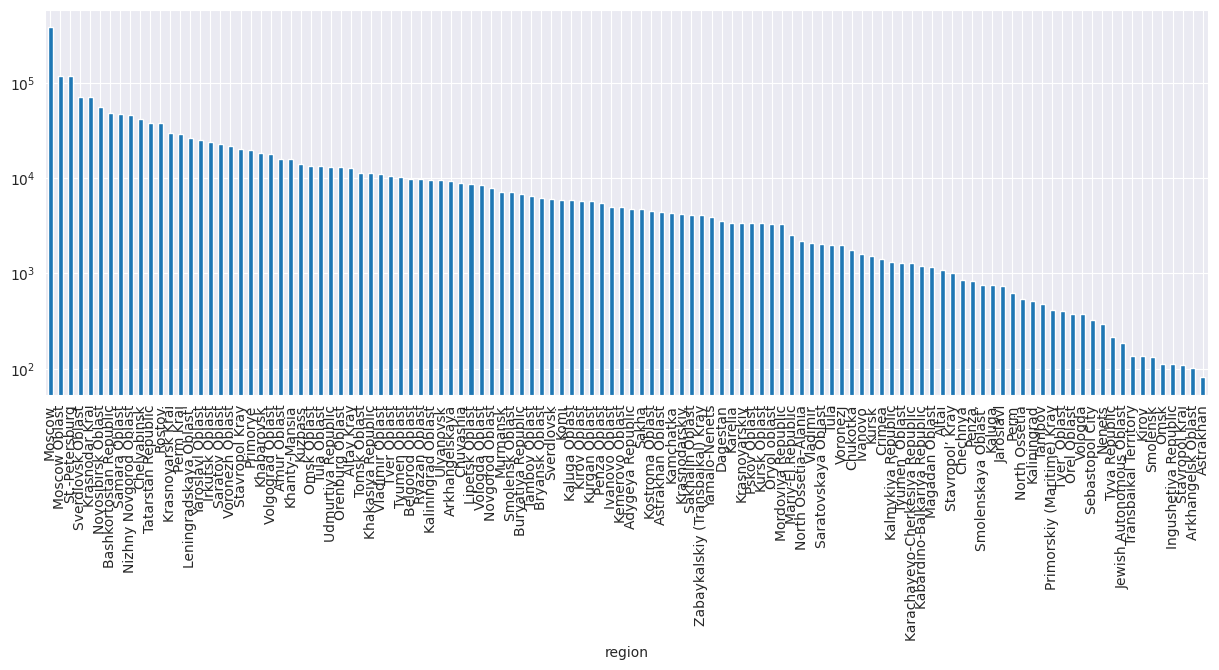

In [107]:
plt.figure(figsize = (15,5))
plt.yscale('log');
data_video['region'].value_counts().plot.bar()

<Axes: xlabel='category'>

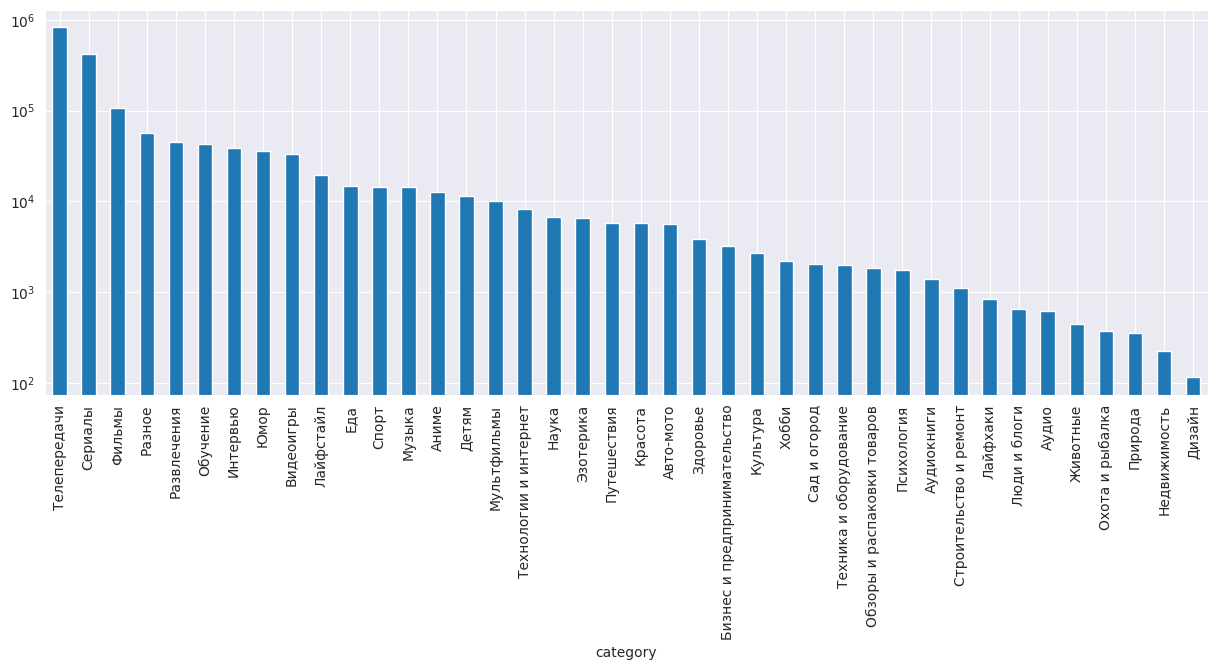

In [98]:
plt.figure(figsize = (15,5))
plt.yscale('log');
data_video['category'].value_counts().plot.bar()

<ipython-input-60-40dd6af84c3a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='sex',data=data_video,palette='colorblind')


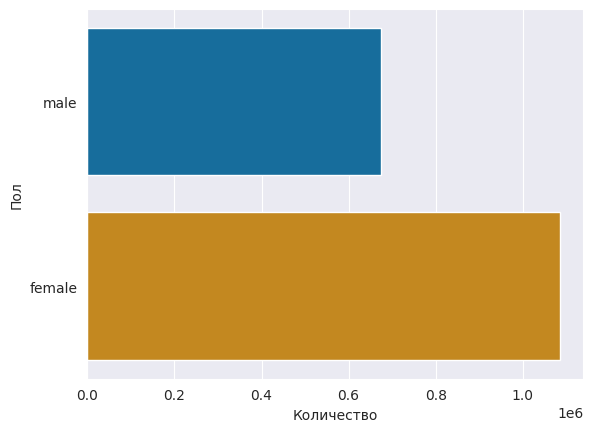

In [60]:
sns.set_style('darkgrid')
sns.countplot(y='sex',data=data_video,palette='colorblind')
plt.xlabel('Количество')
plt.ylabel('Пол')
plt.show()

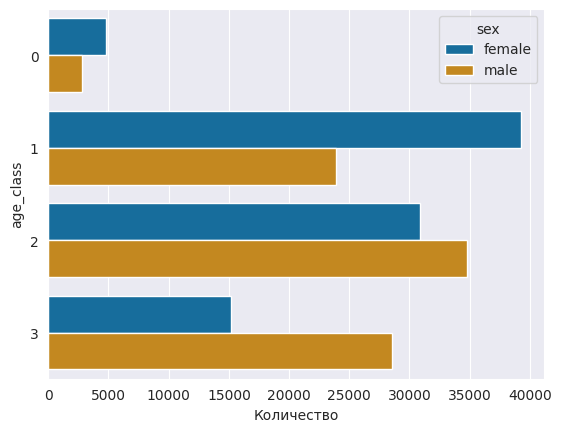

In [61]:
sns.set_style('darkgrid')
sns.countplot(y='age_class',data=targets,palette='colorblind',hue ='sex')
plt.xlabel('Количество')
plt.ylabel('age_class')
plt.show()

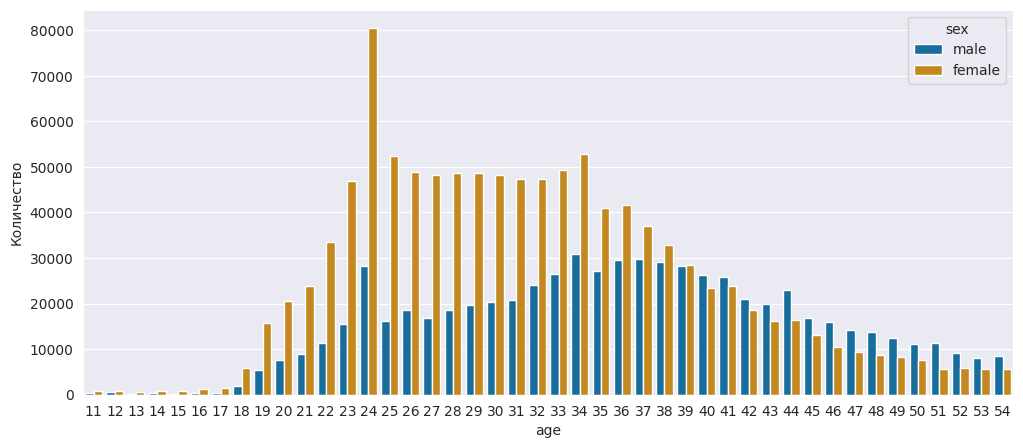

In [91]:
plt.figure(figsize = (12,5))
sns.set_style('darkgrid')
sns.countplot(x='age',data=data_video,palette='colorblind',hue ='sex')
plt.ylabel('Количество')
plt.xlabel('age')
plt.show()

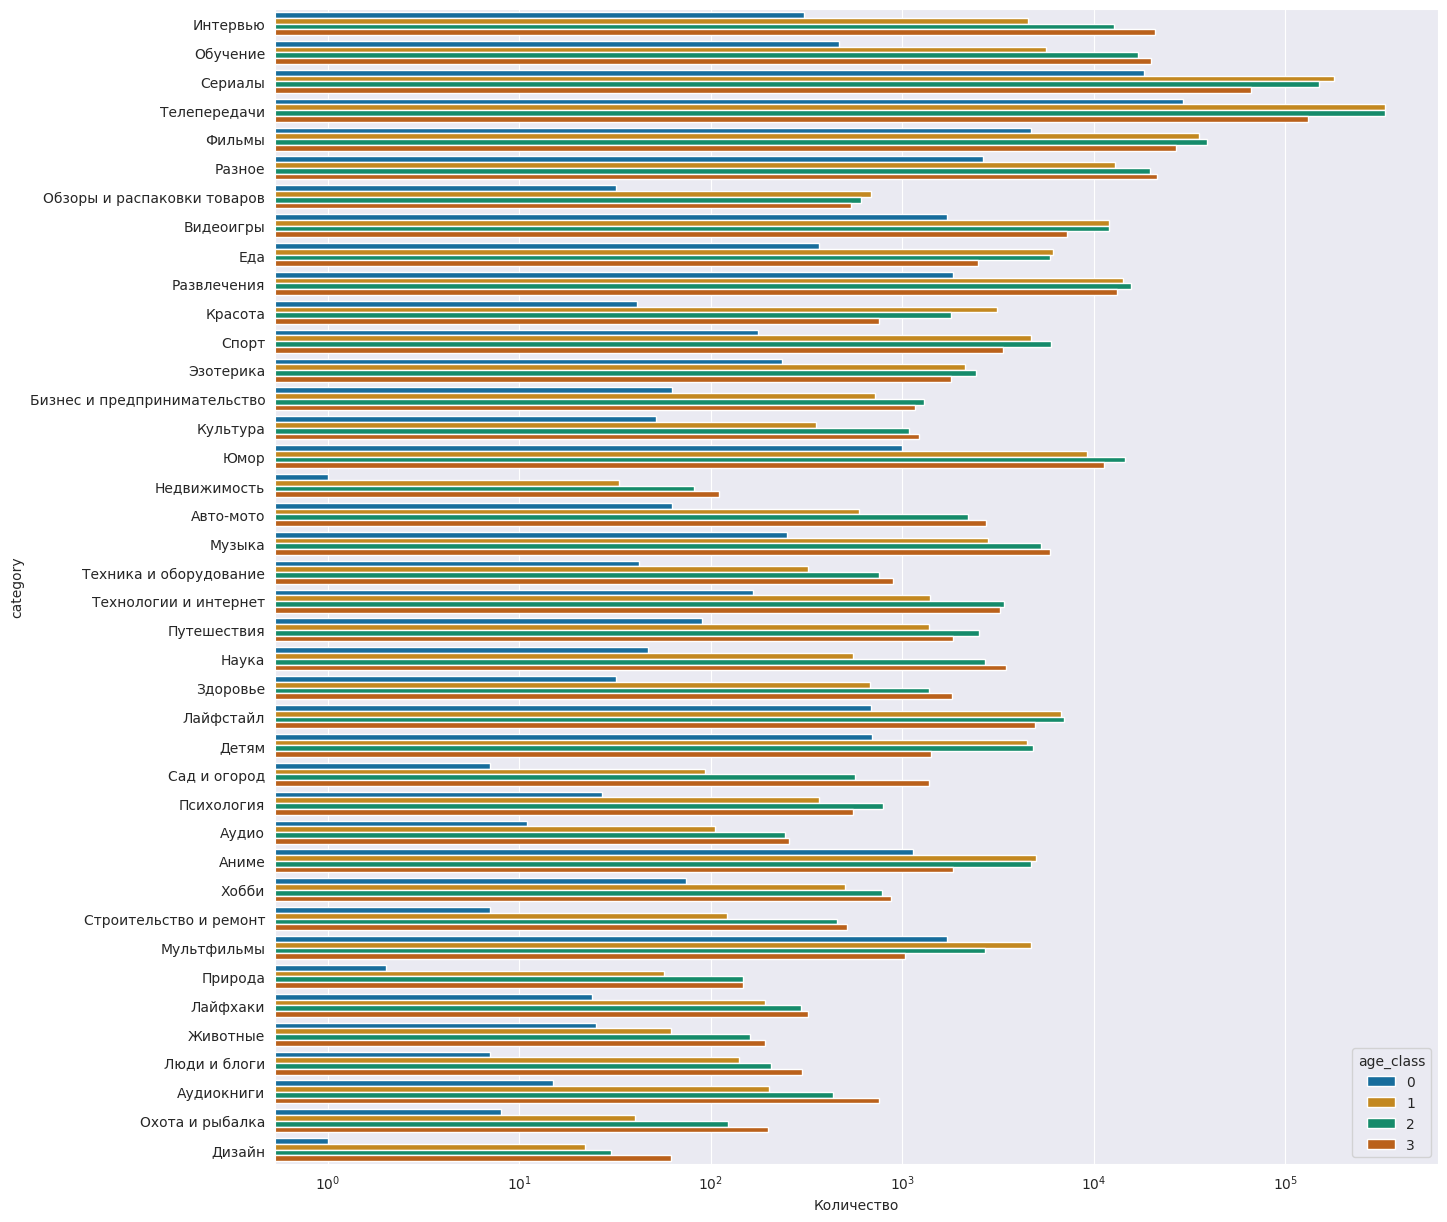

In [101]:
plt.figure(figsize = (15,15))
sns.set_style('darkgrid')
sns.countplot(y='category',data=data_video ,palette='colorblind',hue ='age_class')
plt.xlabel('Количество')
plt.ylabel('category')
plt.xscale('log');
plt.show()

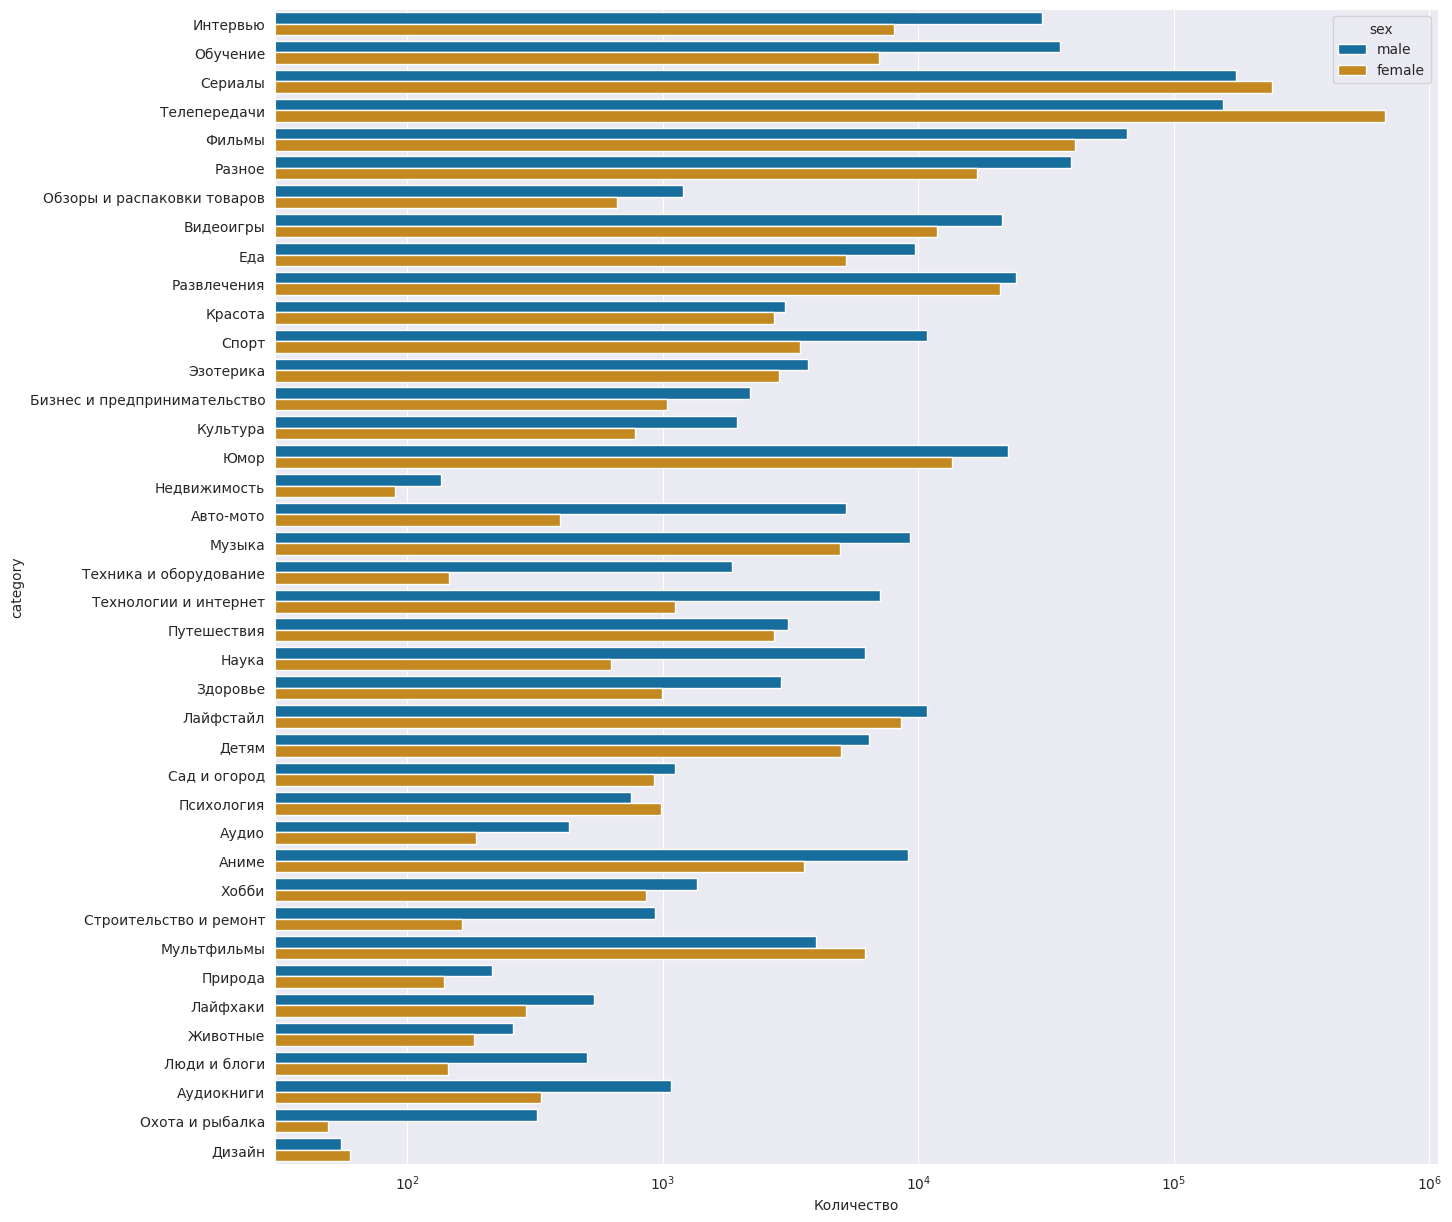

In [102]:
plt.figure(figsize = (15,15))
sns.set_style('darkgrid')
sns.countplot(y='category',data=data_video ,palette='colorblind',hue ='sex')
plt.xlabel('Количество')
plt.ylabel('category')
plt.xscale('log');
plt.show()

In [72]:
#data_vid = data_video[(data_video['category']!= 'Телепередачи') & (data_video['category']!= 'Сериалы')]

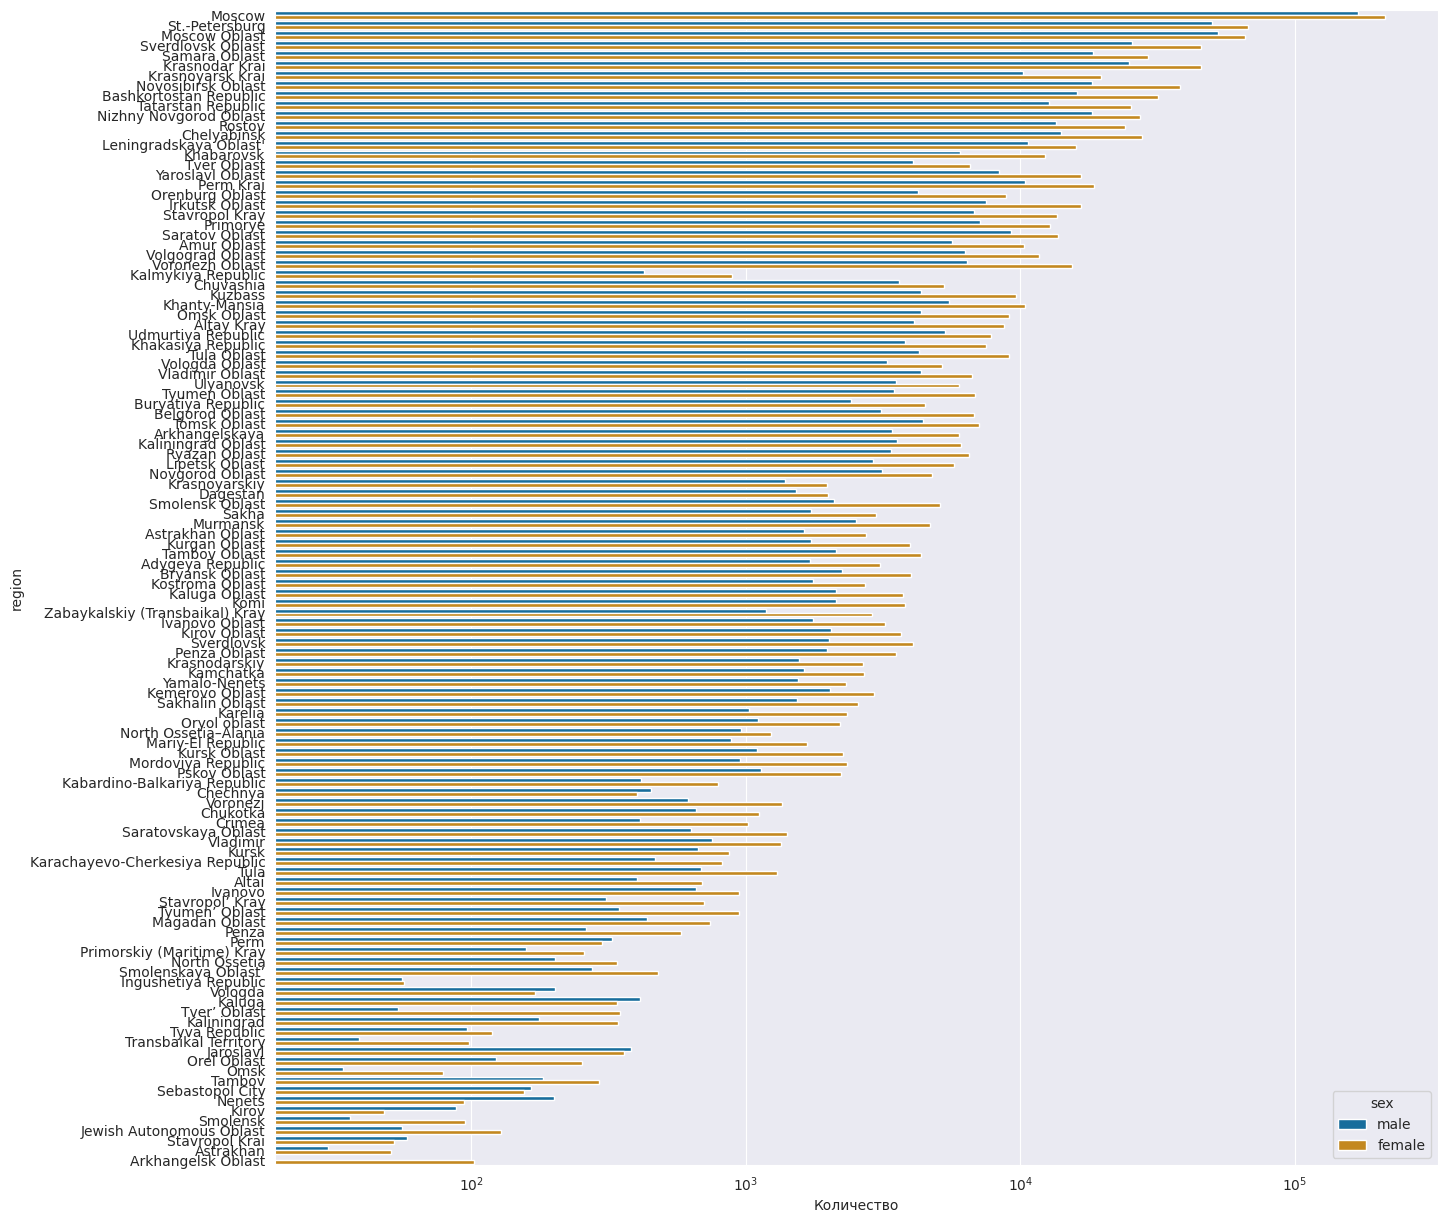

In [111]:
plt.figure(figsize = (15,15))
sns.set_style('darkgrid')
sns.countplot(y='region',data=data_video ,palette='colorblind',hue ='sex')
plt.xlabel('Количество')
plt.ylabel('region')
plt.xscale('log');
plt.show()

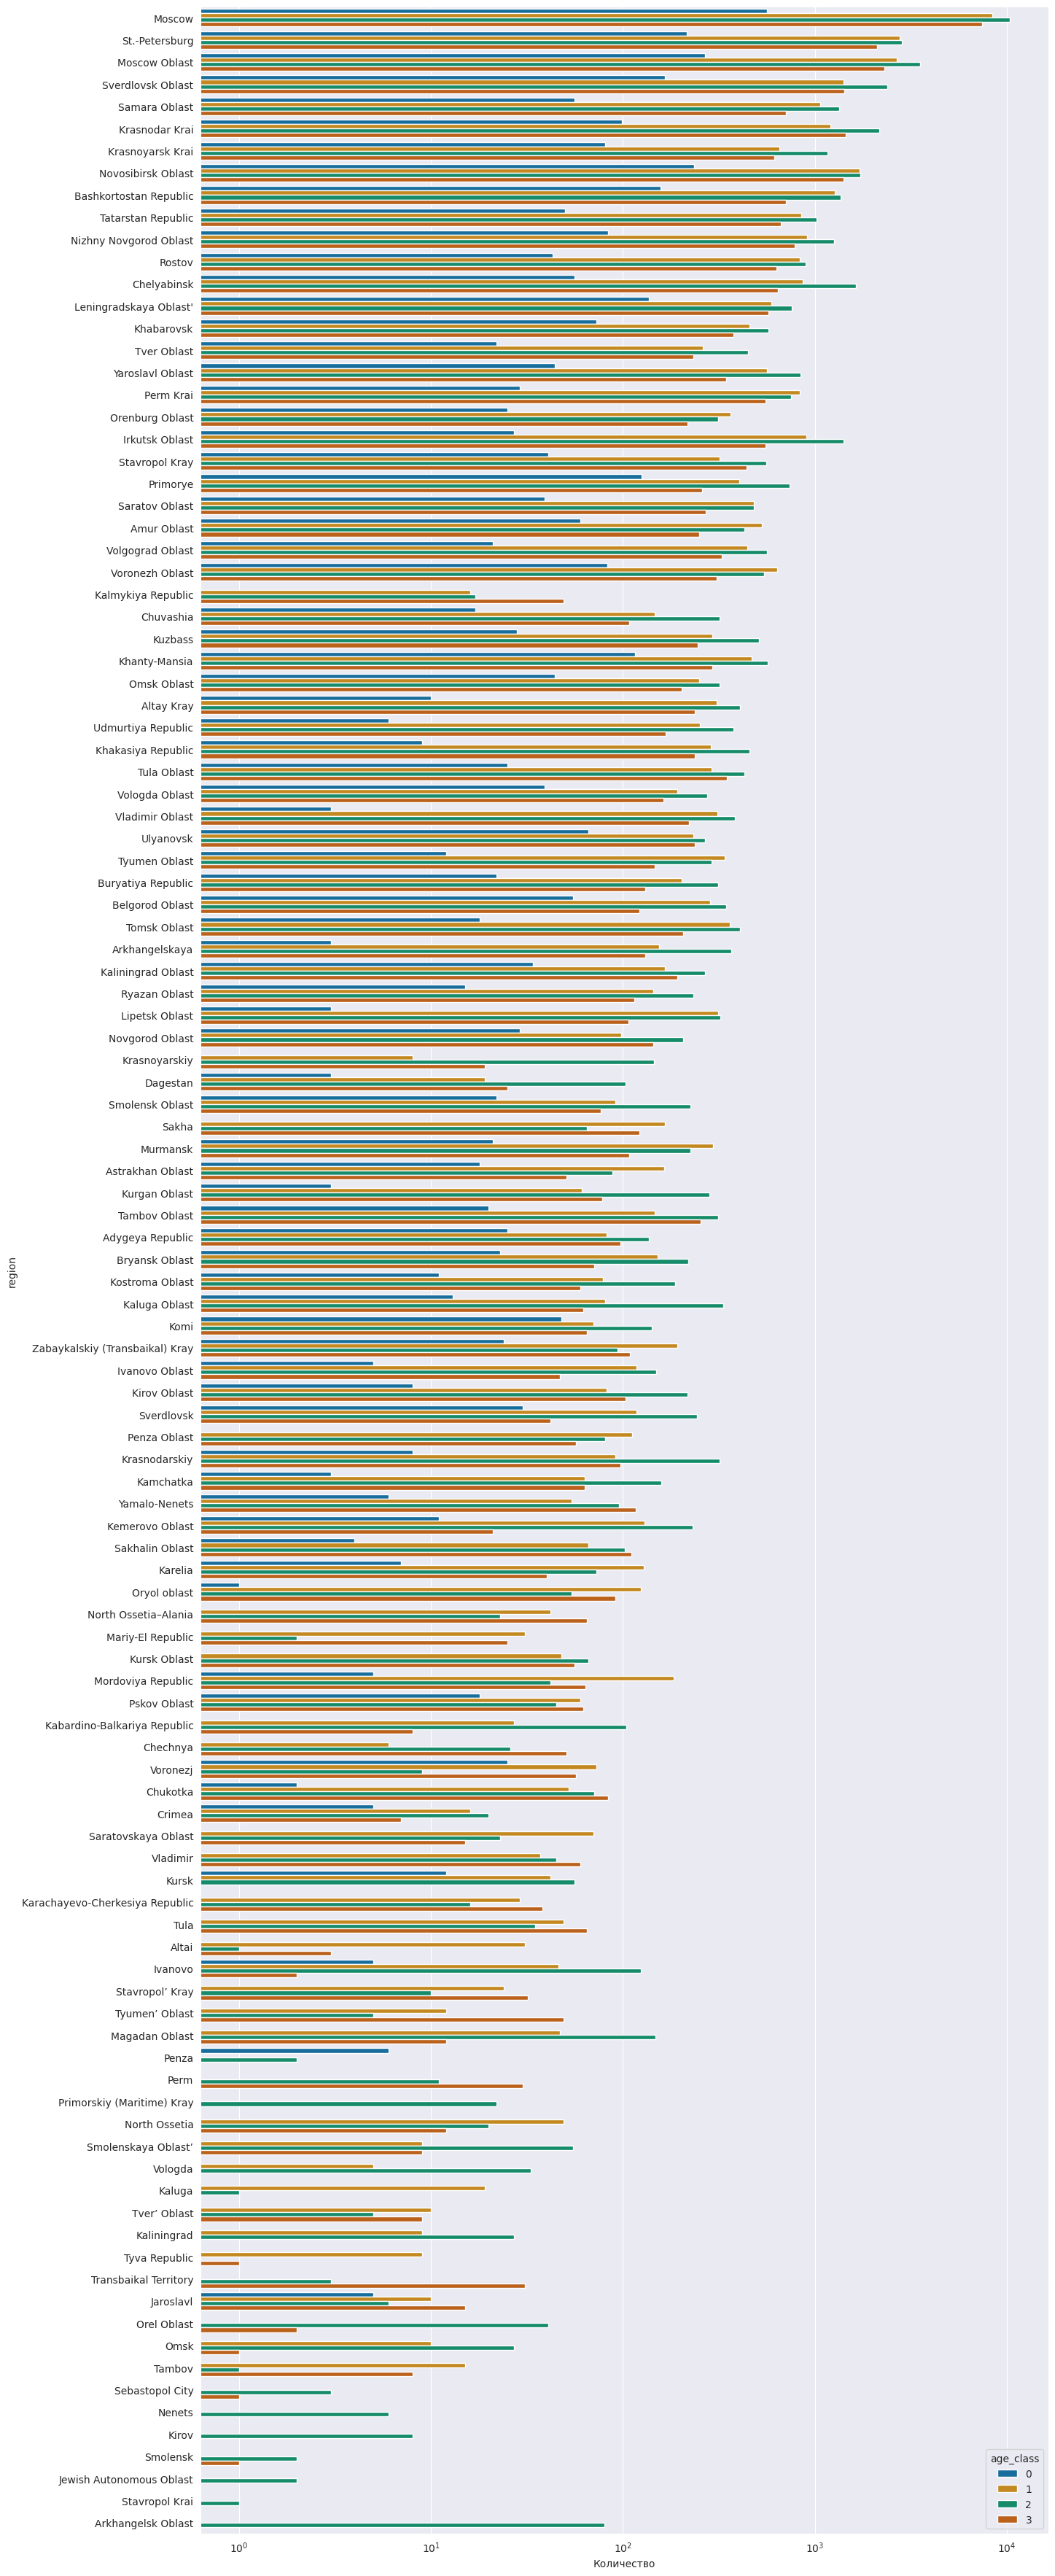

In [115]:
plt.figure(figsize = (15,45))
sns.set_style('darkgrid')
sns.countplot(y='region',data=data_vid ,palette='colorblind',hue ='age_class')
plt.xlabel('Количество')
plt.ylabel('region')
plt.xscale('log');
plt.show()

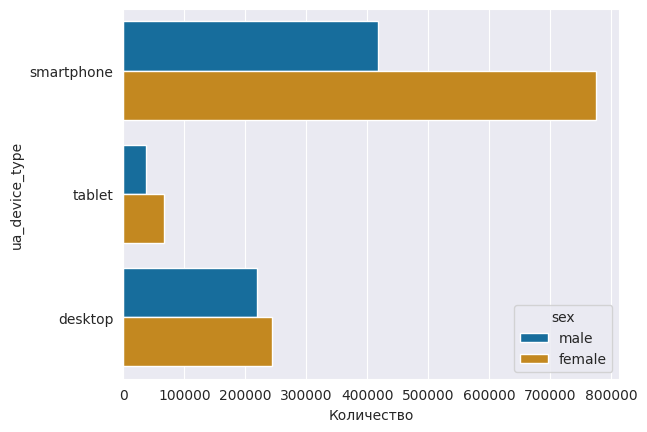

In [74]:
sns.set_style('darkgrid')
sns.countplot(y='ua_device_type',data=data_video ,palette='colorblind',hue ='sex')
plt.xlabel('Количество')
plt.ylabel('ua_device_type')
plt.show()

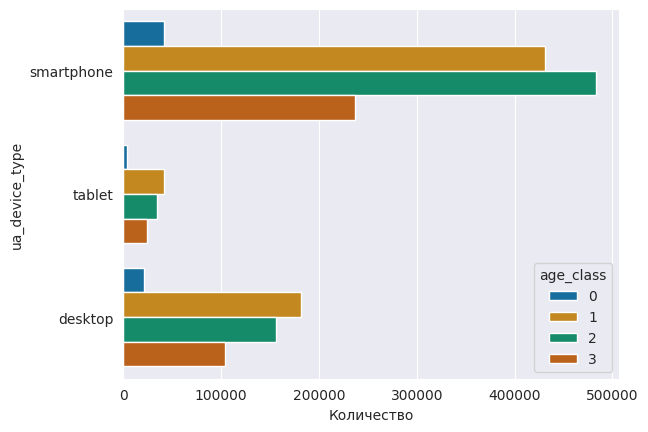

In [85]:
sns.set_style('darkgrid')
sns.countplot(y='ua_device_type',data=data_video ,palette='colorblind',hue ='age_class')
plt.xlabel('Количество')
plt.ylabel('ua_device_type')
plt.show()

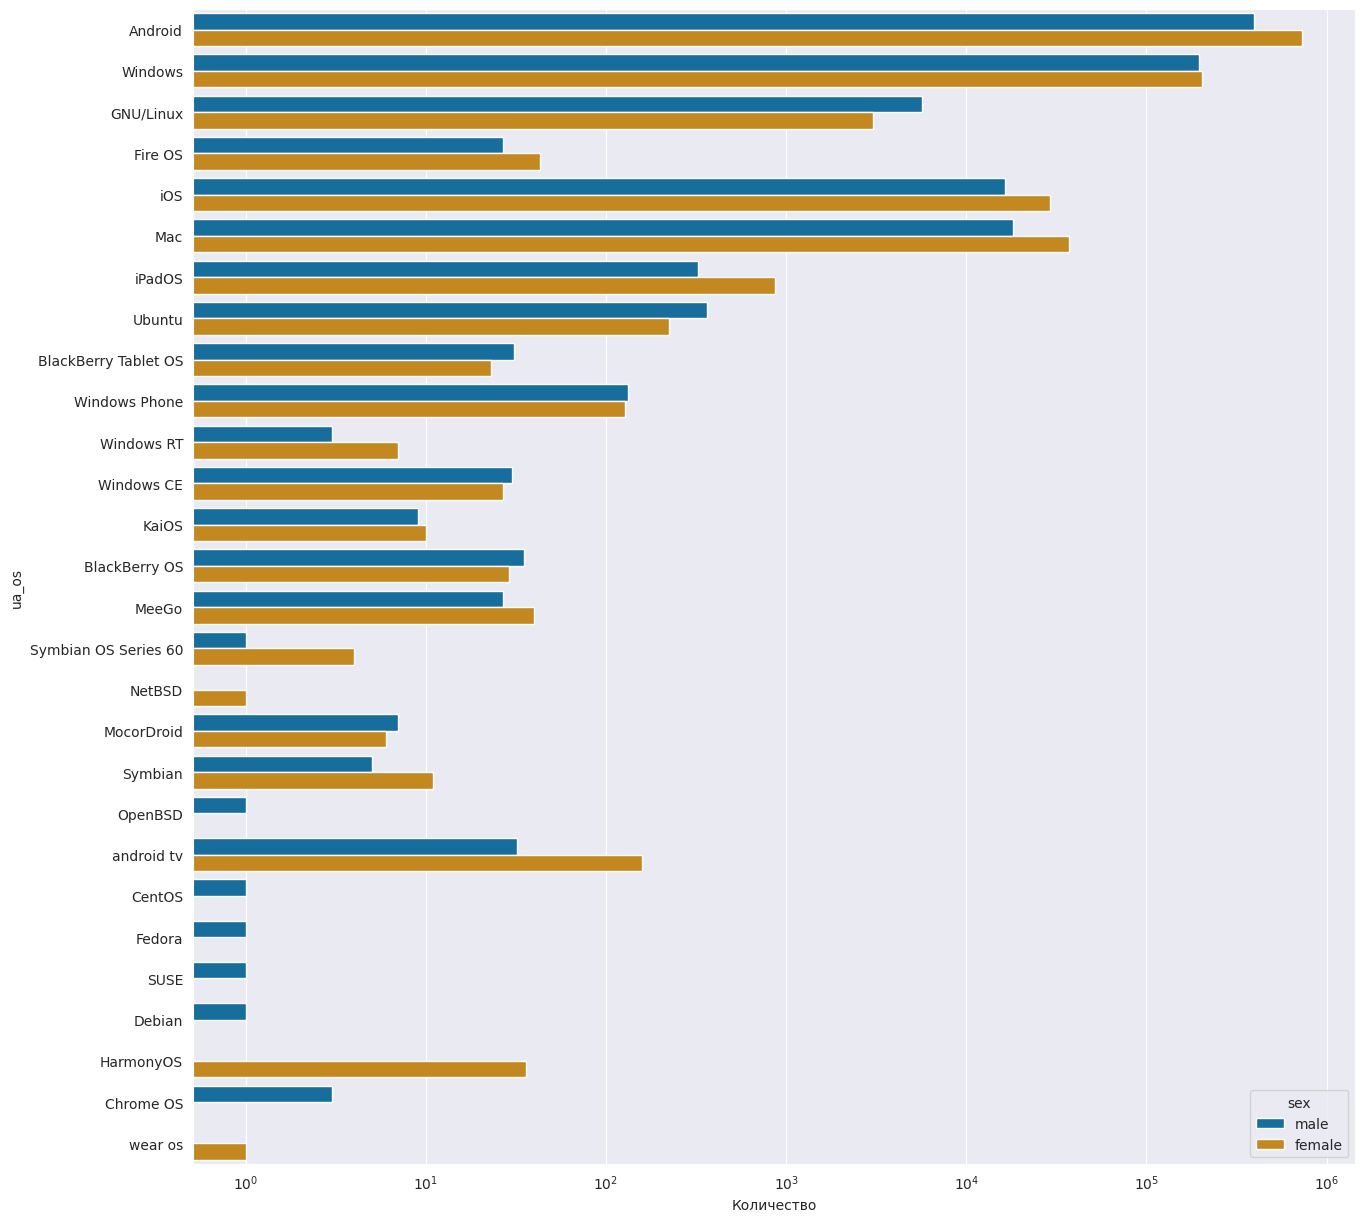

In [108]:
plt.figure(figsize = (15,15))
sns.set_style('darkgrid')
sns.countplot(y='ua_os',data=data_video ,palette='colorblind',hue ='sex')
plt.xlabel('Количество')
plt.ylabel('ua_os')
plt.xscale('log');
plt.show()

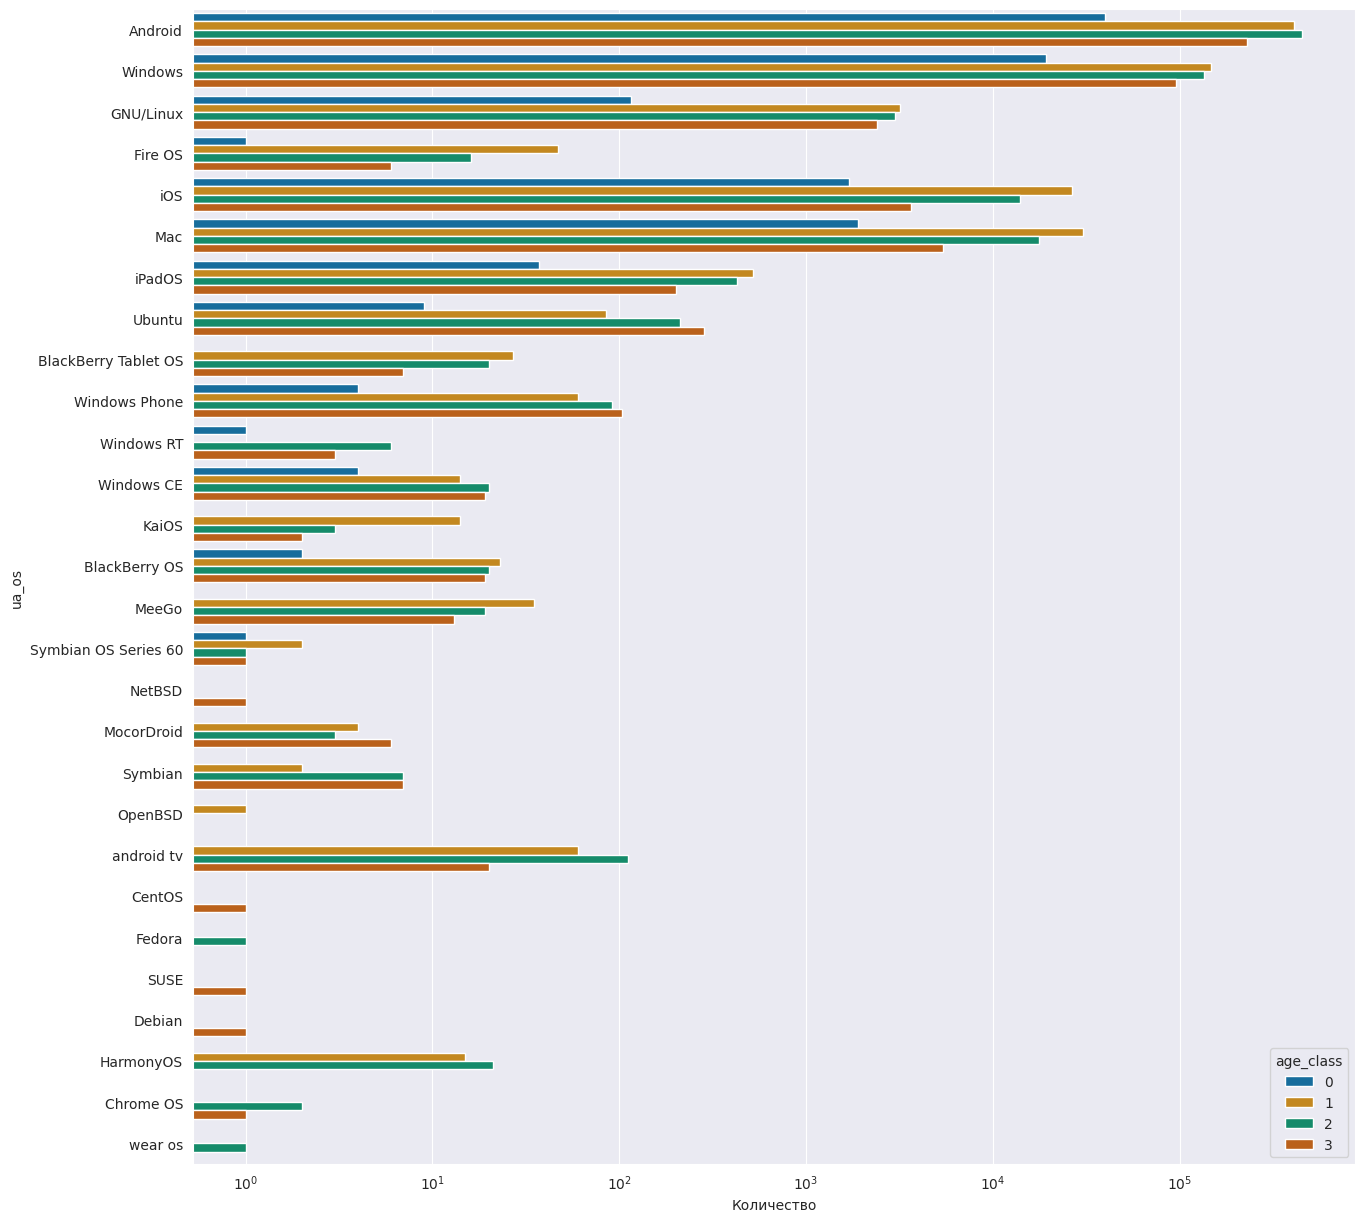

In [109]:
plt.figure(figsize = (15,15))
sns.set_style('darkgrid')
sns.countplot(y='ua_os',data=data_video ,palette='colorblind',hue ='age_class')
plt.xlabel('Количество')
plt.ylabel('ua_os')
plt.xscale('log');
plt.show()

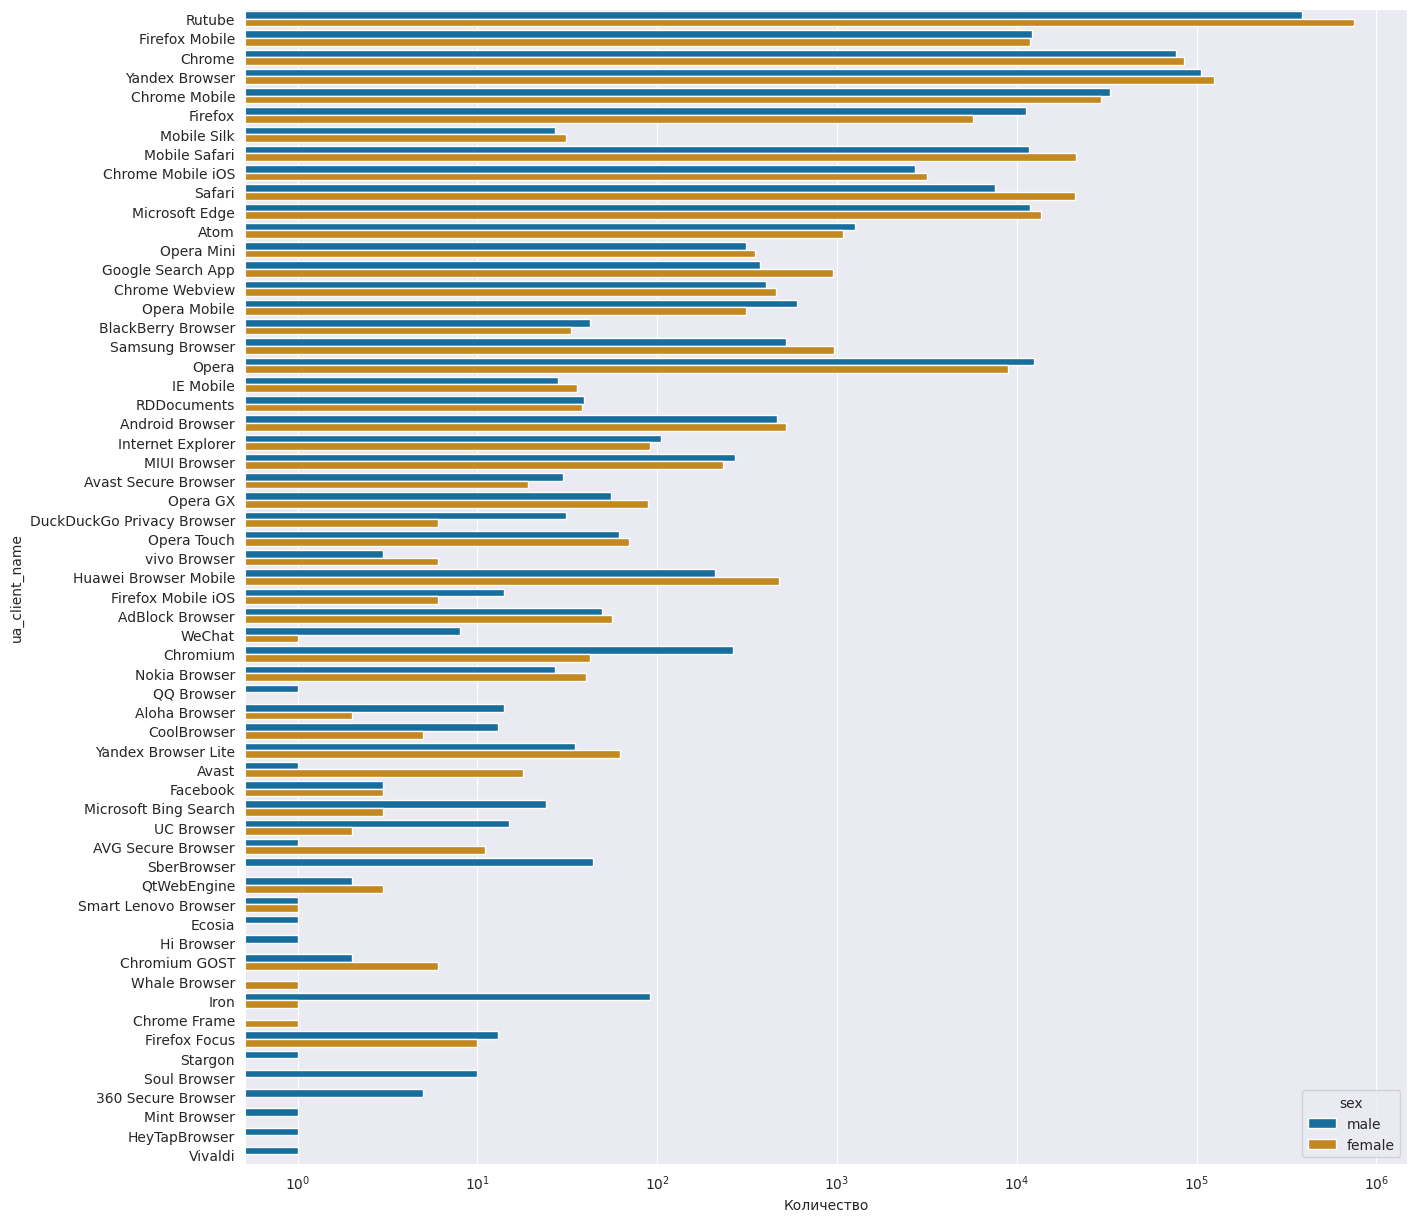

In [117]:
plt.figure(figsize = (15,15))
sns.set_style('darkgrid')
sns.countplot(y='ua_client_name',data=data_video ,palette='colorblind',hue ='sex')
plt.xlabel('Количество')
plt.ylabel('ua_client_name')
plt.xscale('log');
plt.show()

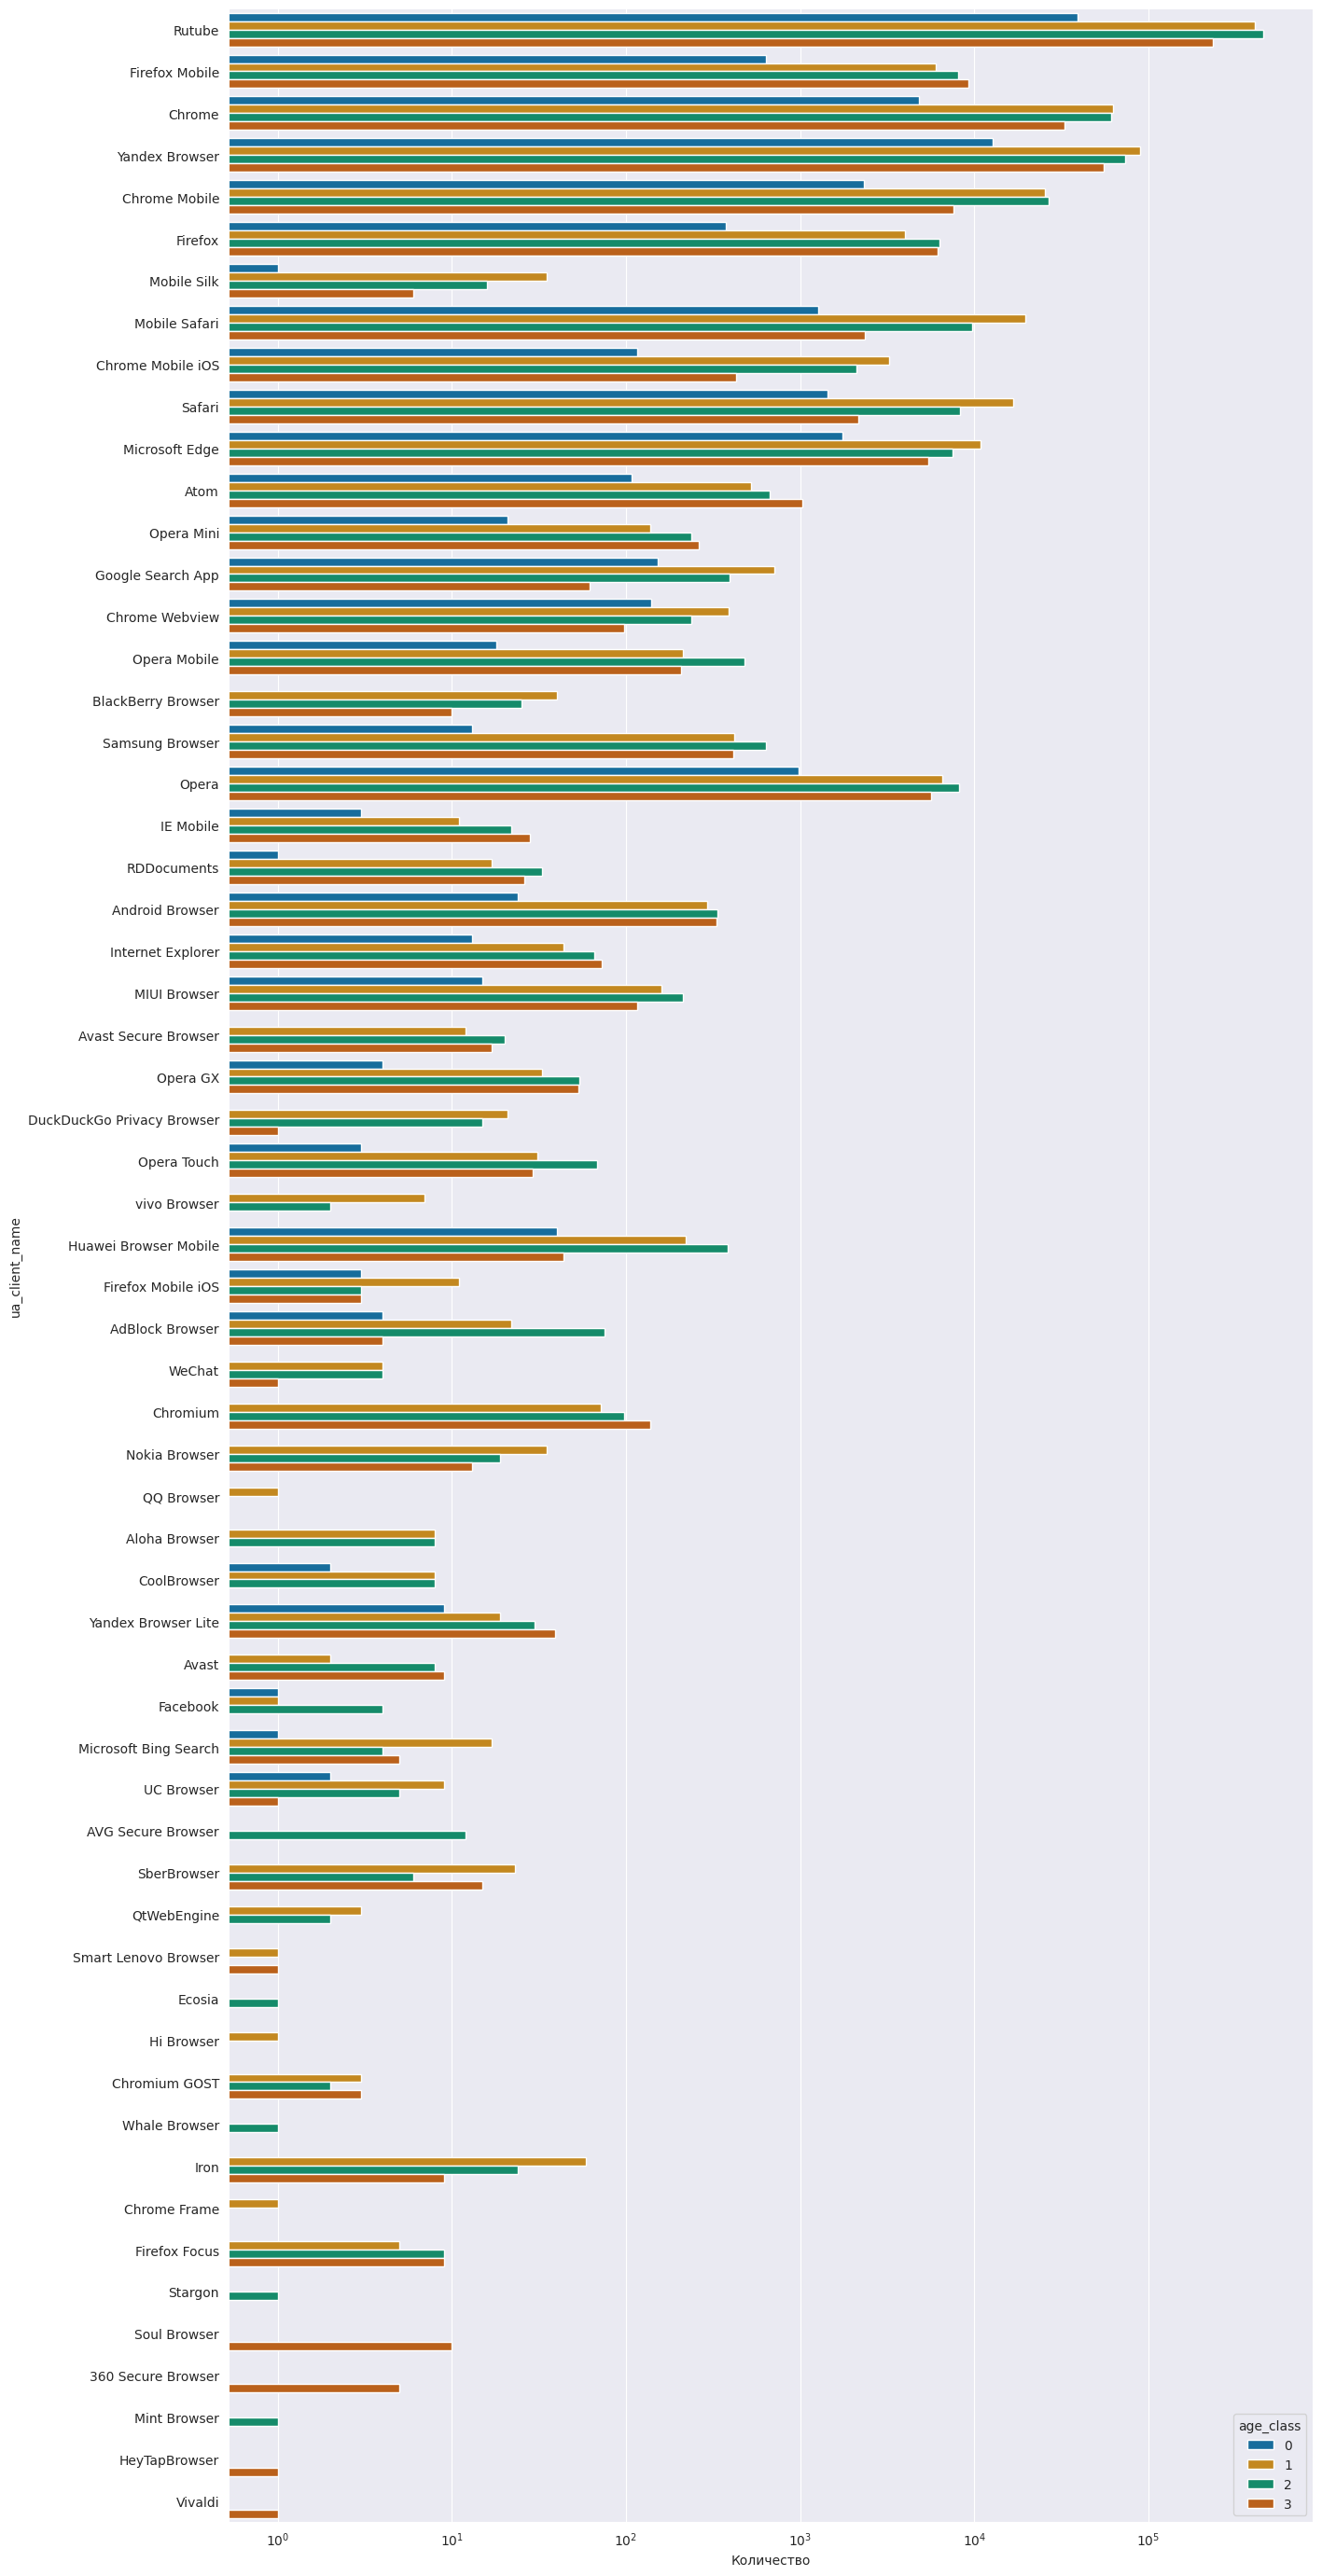

In [118]:
plt.figure(figsize = (15,35))
sns.set_style('darkgrid')
sns.countplot(y='ua_client_name',data=data_video ,palette='colorblind',hue ='age_class')
plt.xlabel('Количество')
plt.ylabel('ua_client_name')
plt.xscale('log');
plt.show()

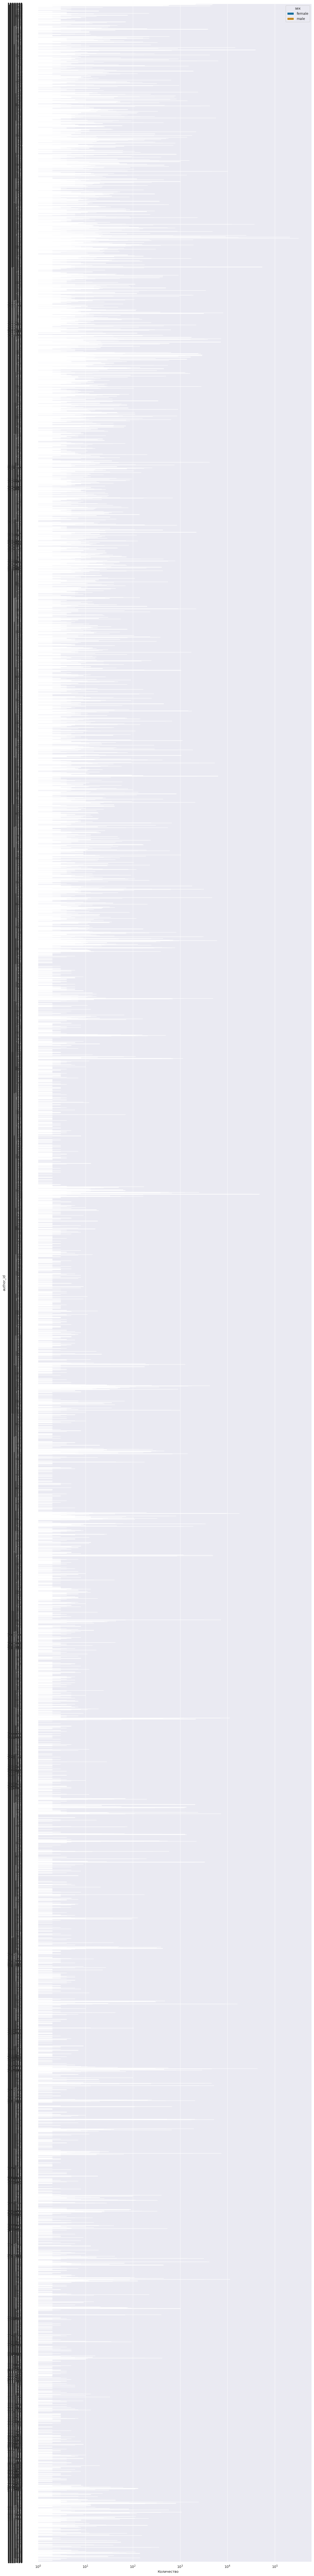

In [120]:
plt.figure(figsize = (15,135))
sns.set_style('darkgrid')
sns.countplot(y='author_id',data=data_video ,palette='colorblind',hue ='sex')
plt.xlabel('Количество')
plt.ylabel('author_id')
plt.xscale('log');
plt.show()

In [ ]:
plt.figure(figsize = (15,15))
sns.set_style('darkgrid')
sns.countplot(y='category',data=data_video ,palette='colorblind',hue = 'sex'  #'age_class')
plt.xlabel('Количество')
plt.ylabel('category')
plt.xscale('log');
plt.show()

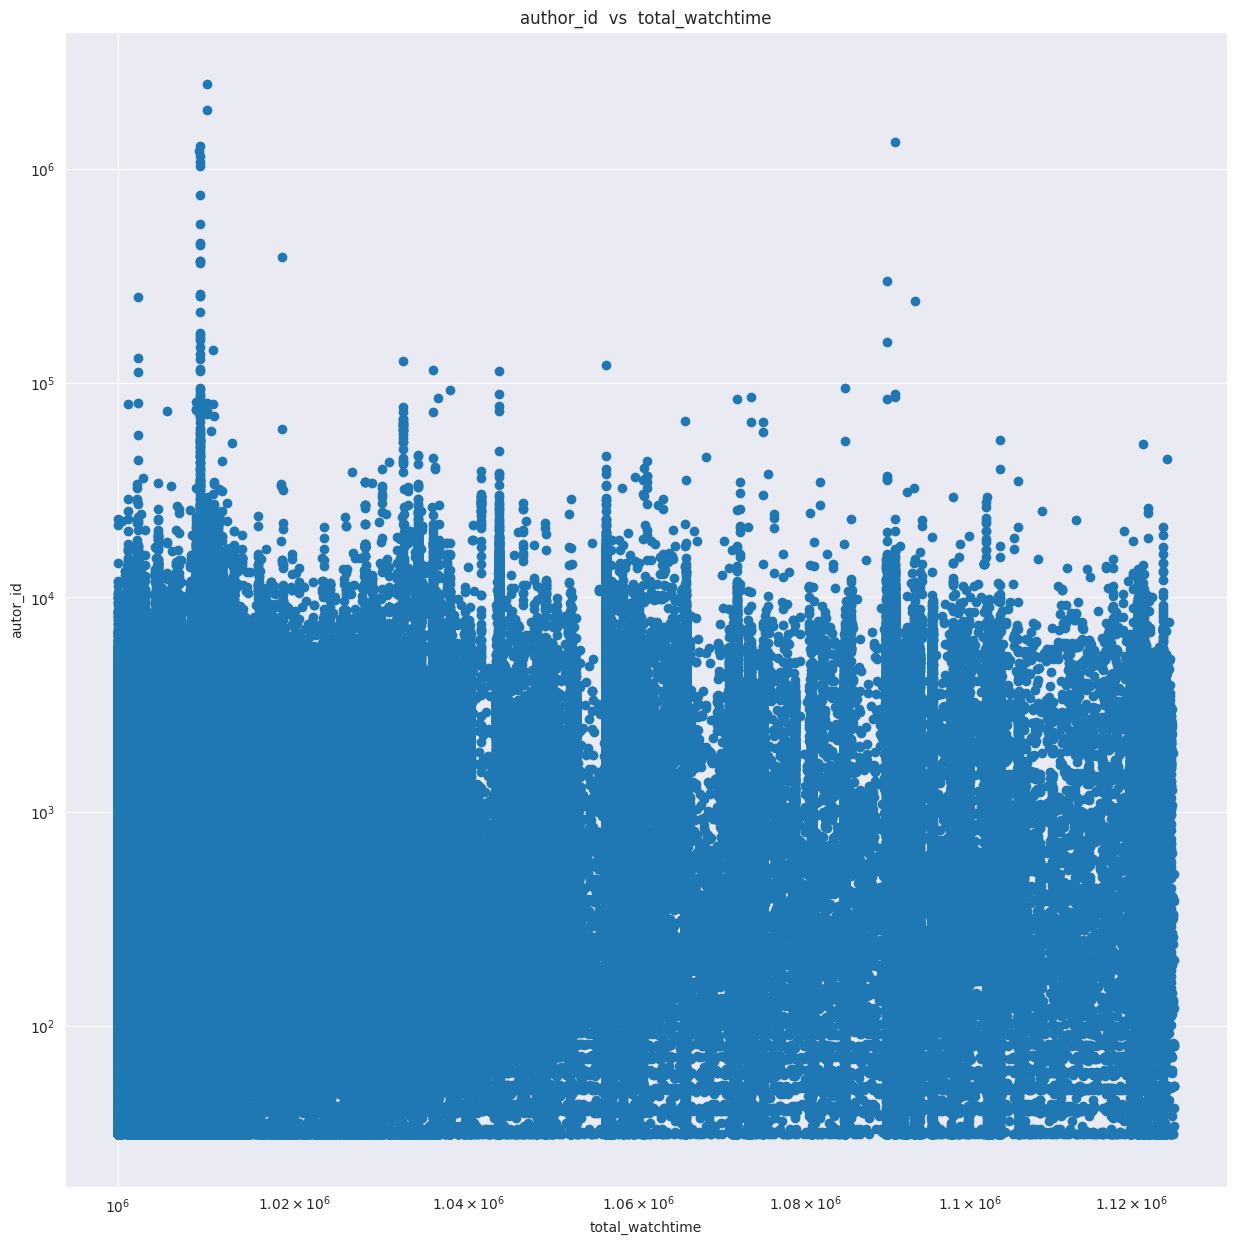

In [126]:
plt.figure(figsize = (15,15))
plt.scatter(data_video.author_id, data_video.total_watchtime)
plt.xlabel('total_watchtime')
plt.ylabel('autor_id')
plt.yscale('log');
plt.xscale('log');
plt.title('author_id  vs  total_watchtime');

In [ ]:
plt.figure(figsize = (15,15))
plt.scatter(data_video.author_id, data_video.total_watchtime)
plt.xlabel('total_watchtime')
plt.ylabel('categoryautor_id')
plt.yscale('log');
plt.title('author_id  vs  total_watchtime');

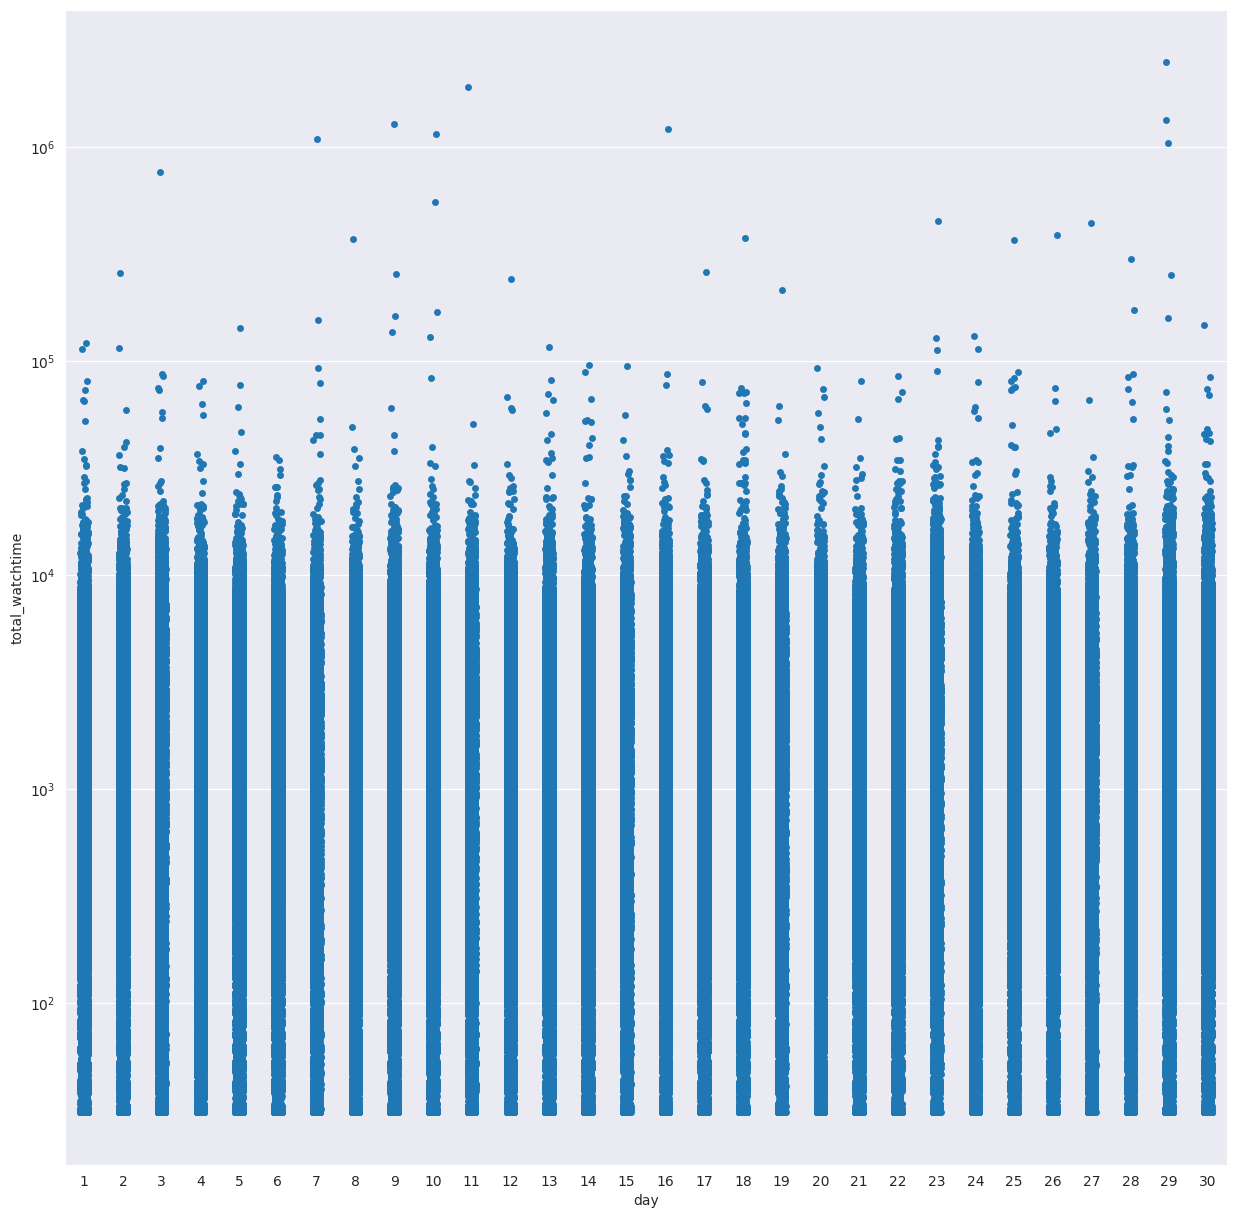

In [128]:
plt.figure(figsize = (15,15))
plt.yscale('log');
sns.stripplot(x = 'day', y = 'total_watchtime', data = data_video);

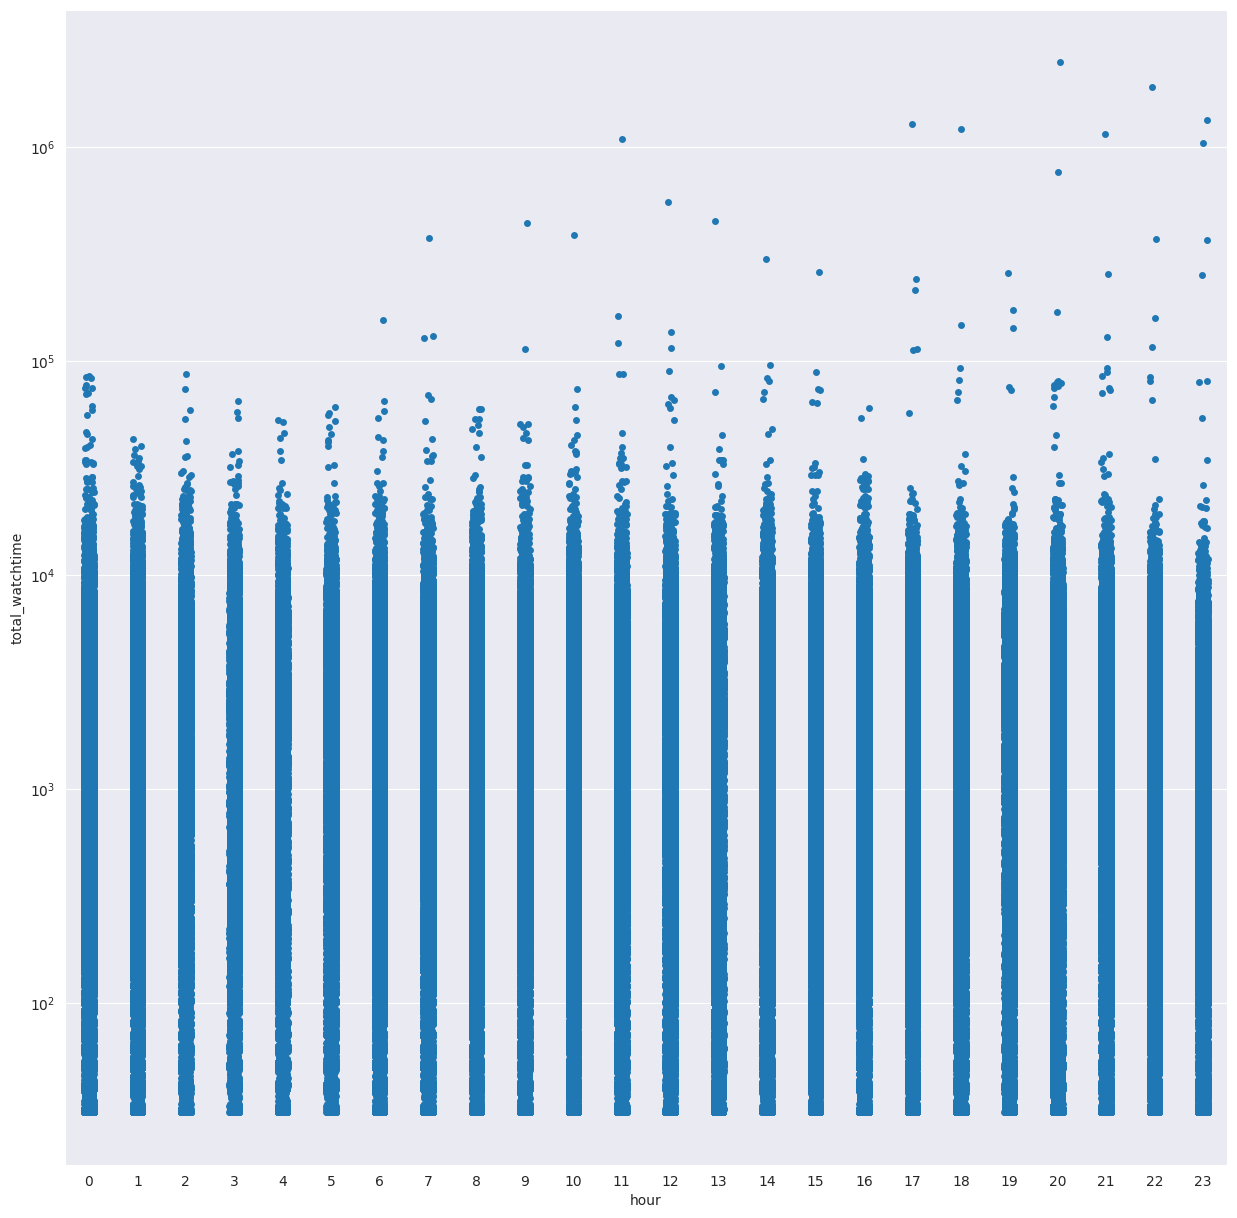

In [129]:
plt.figure(figsize = (15,15))
plt.yscale('log');
sns.stripplot(x = 'hour', y = 'total_watchtime', data = data_video);

In [83]:
data_video.corr()

ValueError: could not convert string to float: 'male'

In [ ]:
grid = sns.FacetGrid(dataframe, col="Region", hue="Region", col_wrap=5)
grid.map(sns.scatterplot, "Economy (GDP per Capita)", "Health (Life Expectancy)")
grid.add_legend();    #https://pythonru.com/biblioteki/seaborn-plot

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

df = pd.read_csv('Downloads/2016.csv')

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = df['Happiness Score']
y = df['Economy (GDP per Capita)']
z = df['Health (Life Expectancy)']

ax.set_xlabel("Счастье")
ax.set_ylabel("Экономика")
ax.set_zlabel("Здоровье")

ax.scatter(x, y, z)

plt.show()

In [ ]:
FFMC = dataframe["FFMC"]
DMC = dataframe["DMC"]
DC = dataframe["DC"]
RH = dataframe["RH"]
ISI = dataframe["ISI"]
temp = dataframe["temp"]

In [ ]:
sns.boxplot(x=DMC);

In [ ]:
sns.boxplot(x=dataframe["day"], y=DMC);

In [ ]:

КОПИРОВАТЬ
df = pd.DataFrame(data=dataframe, columns=["FFMC", "DMC", "DC", "ISI"])
sns.boxplot(x="variable", y="value", data=pd.melt(df));

In [ ]:
data_df['model'].unique()


array(['HGST HDS5C4040ALE630', 'HGST HMS5C4040BLE640',
       'TOSHIBA MQ01ABF050M', 'HGST HMS5C4040ALE640', 'WDC WD5000LPVX',
       'ST4000DM000', 'CT250MX500SSD1', 'ST500LM012 HN',
       'HGST HUS726040ALE610', 'Hitachi HDS5C4040ALE630', 'Seagate SSD',
       'WDC WD5000BPKT', 'ST16000NM001G',
       'Seagate BarraCuda SSD ZA250CM10002', 'WDC WD60EFRX',
       'ST6000DX000', 'ST500LM030', 'ST6000DM001', 'ST8000DM002',
       'TOSHIBA HDWE160', 'Seagate BarraCuda SSD ZA500CM10002',
       'ST6000DM004', 'TOSHIBA MQ01ABF050', 'ST4000DM005', 'ST4000DM004',
       'Seagate BarraCuda 120 SSD ZA250CM10003', 'TOSHIBA MD04ABA400V',
       'WDC WDS250G2B0A', 'ST8000NM0055', 'WD Blue SA510 2.5 250GB',
       'Seagate BarraCuda SSD ZA2000CM10002', 'HGST HMS5C4040BLE641',
       'HGST HDS724040ALE640', 'HGST HUH728080ALE600', 'ST8000DM005',
       'HGST HUH728080ALE604', 'ST8000NM000A', 'WDC WD5000LPCX',
       'HGST HUS728T8TALE6L4', 'ST10000NM001G', 'ST10000NM0086',
       'Seagate FireCuda 